# Cálculo de Entropia

## Discreta

In [ ]:
import numpy as np
from scipy.stats import entropy, rv_discrete
np.random.seed(1)

values = [1, 2, 3]
probabilities = [0.2, 0.3, 0.5]

dist = rv_discrete(values=(values, probabilities))
data = np.array(dist.rvs(size = 1000))

estimated_probabilities = [np.sum(data == i)/np.size(data) for i in set(data) ]

# counts, bins = np.histogram(data, bins=3, density=False)
# pmf = counts / len(data)
#* Não sei como ajustar automaticamente a saída do bins pro plot
 
print('PMF estimada: ', estimated_probabilities)
print('PMF real:     ', probabilities)

print('Entropia estimada: ', entropy(estimated_probabilities))
print('Entropia real:     ', entropy(probabilities))

print('Distância KL-1: ', entropy(estimated_probabilities, probabilities))
print('Distância KL-2: ', entropy(probabilities, estimated_probabilities))  

PMF estimada:  [0.203, 0.291, 0.506]
PMF real:      [0.2, 0.3, 0.5]
Entropia estimada:  1.0276098398302924
Entropia real:      1.0296530140645737
Distância KL-1:  0.0001946158160097168
Distância KL-2:  0.0001957543140255454


## Contínua

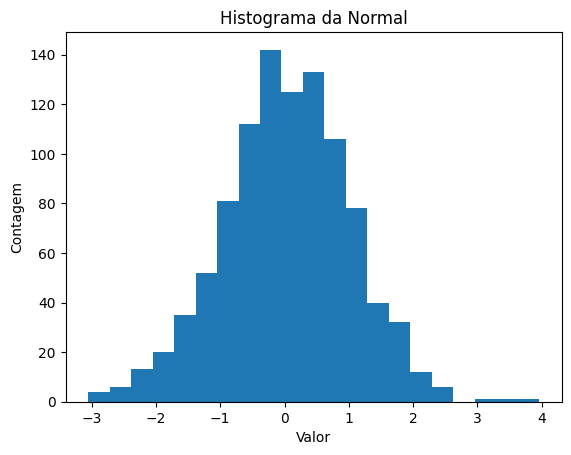

P(x > 0):  0.627
Entropia estimada:  2.43755888895662


In [ ]:
# Histograma
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)

data = np.random.normal(size=(1000))

counts, bins = np.histogram(data, bins=20, density=False)
idx = np.where((bins > 0))[0]
probability = np.sum(counts[idx - 1])/data.size

plt.hist(data, bins.size)
plt.xlabel('Valor')
plt.ylabel('Contagem')
plt.title('Histograma da Normal')
plt.show()

print('P(x > 0): ', probability)

print('Entropia estimada: ', entropy(counts/data.size))


Entropia estimada:  1.416449063083199
Entropia real:      1.4189385332046727


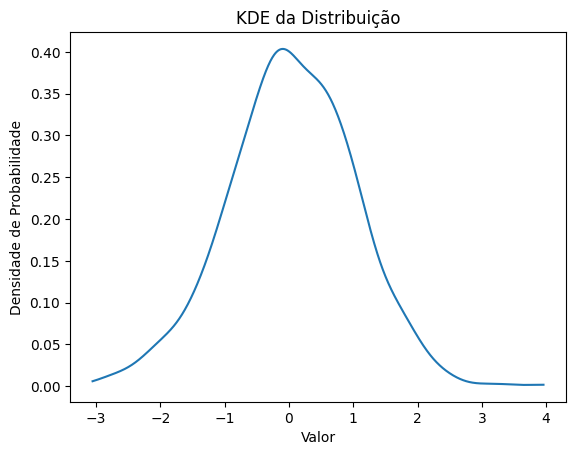

In [ ]:
# KDE
from scipy.stats import gaussian_kde
np.random.seed(1)

data = np.random.normal(size=(1000))

kde = gaussian_kde(data)
x_grid = np.linspace(data.min(), data.max(), 1000)

density = kde(x_grid)

epsilon = 1e-12
entropia = -np.trapz(density * np.log(density + epsilon), x_grid)

print('Entropia estimada: ',entropia)
print('Entropia real:     ', 0.5*(np.log(2*np.pi) + 1))

plt.plot(x_grid, density)
plt.xlabel('Valor')
plt.ylabel('Densidade de Probabilidade')
plt.title('KDE da Distribuição')
plt.show()

# Informação Mútua

## Teste de biblioteca para cálculo de IM

In [3]:
from sklearn.feature_selection import mutual_info_regression
from NPEET.npeet import entropy_estimators as ee
from collections import Counter, defaultdict
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import time


np.random.seed(0)

# --- Configurações Iniciais ---
n_samples_global = int(1e4) # Amostras para testes com dados uniformes
noise_scale_global = 1.5
k_values_knn = [3, 5, 10]
n_bins_values_binning = [10, 20, 40]
n_jobs_values_sklearn = [1]
n_features_to_test_uniform = [1, 3, 5] # Para o loop original com dados uniformes
n_features_to_test_gaussian = [1, 2] # Número de features em X para o teste Gaussiano
n_samples_gaussian_analytical = int(5e4) # Amostras para o teste Gaussiano
base_log_manual = np.e


overall_results_list = []
#==============================================================================
# TESTE ANALÍTICO COM DADOS GAUSSIANOS (X MULTIVARIADO, Y UNIVARIADO)
#==============================================================================
print("\n--- INICIANDO TESTE ANALÍTICO COM DADOS GAUSSIANOS (X MULTIVARIADO) ---")

for n_feat_x_analytical in n_features_to_test_gaussian:
    print(f"\n--- Teste Gaussiano com N_Features_X = {n_feat_x_analytical} ---")
    dim_Y_analytical = 1
    total_dims = n_feat_x_analytical + dim_Y_analytical

    # Construir a matriz de covariância Sigma
    # Sigma_XX: Identidade (features X_i são N(0,1) e independentes entre si)
    sigma_xx = np.eye(n_feat_x_analytical)
    # Sigma_YY: Variância de Y (N(0,1))
    sigma_yy_val = 1.0
    sigma_yy = np.array([[sigma_yy_val]])

    # Sigma_XY: Covariâncias entre X_i e Y
    # Vamos criar uma correlação modesta para cada X_i com Y, garantindo Sigma > 0
    # Ex: cov(X_i, Y) = c / sqrt(n_feat_x_analytical) para que sum(cov^2) não exploda
    # Para simplicidade, vamos definir uma correlação alvo para a primeira feature X1 com Y
    # e correlações menores ou zero para as outras, garantindo SPD.
    
    target_overall_correlation_strength = 0.6 # Ajuste este valor
    sigma_xy = np.zeros((n_feat_x_analytical, dim_Y_analytical))
    
    # Exemplo: correlação apenas com a primeira feature de X
    # sigma_xy[0, 0] = target_overall_correlation_strength 
    # Para garantir que a soma dos quadrados das correlações seja < 1 se Sigma_XX=I, Sigma_YY=1:
    # Distribuir a "força de correlação"
    # Se n_feat_x_analytical = 1, rho = target_overall_correlation_strength
    # Se > 1, podemos ter rho_i = target_overall_correlation_strength / sqrt(n_feat_x_analytical)
    # ou definir manualmente para controle
    
    if n_feat_x_analytical == 1:
        sigma_xy[0,0] = target_overall_correlation_strength
    elif n_feat_x_analytical == 2:
        sigma_xy[0,0] = 0.5 # corr(X1, Y)
        sigma_xy[1,0] = 0.3 # corr(X2, Y) -> 0.5^2 + 0.3^2 = 0.25 + 0.09 = 0.34 < 1
    elif n_feat_x_analytical == 3:
        sigma_xy[0,0] = 0.4
        sigma_xy[1,0] = 0.3
        sigma_xy[2,0] = 0.2 # 0.16 + 0.09 + 0.04 = 0.29 < 1
    else: # Default para mais features
         for i in range(n_feat_x_analytical):
            sigma_xy[i,0] = (target_overall_correlation_strength / np.sqrt(n_feat_x_analytical)) * (0.8 + 0.4*np.random.rand()) # Adiciona alguma variação


    # Montar a matriz de covariância completa Sigma
    # Sigma = [[Sigma_XX, Sigma_XY],
    #          [Sigma_YX, Sigma_YY]]
    sigma_yx = sigma_xy.T
    top_block = np.hstack((sigma_xx, sigma_xy))
    bottom_block = np.hstack((sigma_yx, sigma_yy))
    cov_matrix_full_gaussian = np.vstack((top_block, bottom_block))

    # Checar se é positiva definida (Cholesky falhará se não for)
    try:
        np.linalg.cholesky(cov_matrix_full_gaussian)
    except np.linalg.LinAlgError:
        print(f"AVISO: Matriz de covariância não é positiva definida para N_Features_X = {n_feat_x_analytical}. Pulando este caso.")
        # Pode ser necessário ajustar os valores em sigma_xy se isso acontecer
        # Exemplo alternativo mais robusto para Sigma_XY que garante SPD:
        # A = np.random.rand(total_dims, total_dims)
        # cov_matrix_full_gaussian = np.dot(A, A.transpose()) # Garante SPD
        # # E então normalizar para ter variâncias unitárias nas diagonais se desejado,
        # # e extrair/definir as correlações. Isso é mais complexo.
        # # Por ora, a construção manual de sigma_xy acima deve funcionar para os valores dados.
        continue


    mean_full_gaussian = np.zeros(total_dims)
    data_full_gaussian = np.random.multivariate_normal(mean_full_gaussian, cov_matrix_full_gaussian, n_samples_gaussian_analytical)

    X_gaussian_analytical = data_full_gaussian[:, :n_feat_x_analytical]
    Y_gaussian_analytical = data_full_gaussian[:, n_feat_x_analytical] # Y é a última coluna, 1D
    Y_gaussian_analytical_reshaped = Y_gaussian_analytical.reshape(-1, 1) # Para NPEET

    # Calcular MI Teórica I(X;Y)
    det_sigma_xx = np.linalg.det(sigma_xx)
    det_sigma_yy = sigma_yy_val # Já que Y é 1D, |Sigma_YY| = Var(Y)
    det_sigma_full = np.linalg.det(cov_matrix_full_gaussian)

    mi_theoretical_gaussian = np.nan
    if det_sigma_xx > 1e-9 and det_sigma_yy > 1e-9 and det_sigma_full > 1e-9: # Evitar log de <=0 ou divisão por zero
        # Garantir que o argumento do log seja > 0
        log_arg = (det_sigma_xx * det_sigma_yy) / det_sigma_full
        if log_arg > 1e-9:
             mi_theoretical_gaussian = 0.5 * np.log(log_arg)
        else:
            print(f"AVISO: Argumento do log para MI teórica <=0 ({log_arg}). MI será NaN.")
    else:
        print(f"AVISO: Determinante zero ou próximo de zero. MI teórica será NaN.")


    print(f"  MI Teórica (Gaussiana, X {n_feat_x_analytical}-dim): {mi_theoretical_gaussian:.4f} nats")
    param_string_theoretical = f"X_dims={n_feat_x_analytical}, Y_dims=1, CovXY approx {np.mean(np.abs(sigma_xy)):.2f}"


    overall_results_list.append({
        "Method": "Theoretical Gaussian",
        "N_Features_X": n_feat_x_analytical,
        "MI (nats, mean)": mi_theoretical_gaussian,
        "Parameters": param_string_theoretical,
        "Time (s)": 0.0
    })

    # --- 1. Scikit-learn com Dados Gaussianos ---
    # Nota: mutual_info_regression retorna MI(X_i; Y) para cada feature X_i.
    # Vamos calcular a média desses valores. Não é I(X_vec; Y).
    for k_sklearn in k_values_knn:
        for n_jobs_sklearn in n_jobs_values_sklearn:
            params_sklearn = f"k={k_sklearn}, n_jobs={n_jobs_sklearn} (Gaussian Test)"
            start_time = time.time()
            mi_sklearn_per_feature = mutual_info_regression(X_gaussian_analytical, Y_gaussian_analytical, n_neighbors=k_sklearn, n_jobs=n_jobs_sklearn, random_state=0)
            mi_sklearn_val = np.mean(mi_sklearn_per_feature) # Média das MIs feature-wise
            end_time = time.time()
            time_sklearn = end_time - start_time
            overall_results_list.append({
                "Method": f"Scikit-learn (n_jobs={n_jobs_sklearn})",
                "N_Features_X": n_feat_x_analytical,
                "MI (nats, mean)": mi_sklearn_val,
                "Parameters": params_sklearn,
                "Time (s)": time_sklearn
            })

    # --- 2. NPEET com Dados Gaussianos ---
    # Estima I(X_vec; Y_vec)
    for k_npeet in k_values_knn:
        params_npeet = f"k={k_npeet} (Gaussian Test)"
        start_time = time.time()
        try:
            # X_gaussian_analytical já é (samples, n_feat_x_analytical)
            # Y_gaussian_analytical_reshaped é (samples, 1)
            mi_npeet_val = ee.mi(X_gaussian_analytical, Y_gaussian_analytical_reshaped, k=k_npeet, base=base_log_manual)
        except Exception as e:
            print(f"  Erro no NPEET com dados Gaussianos (X {n_feat_x_analytical}-dim): {e}")
            mi_npeet_val = np.nan
        end_time = time.time()
        time_npeet = end_time - start_time
        overall_results_list.append({
            "Method": "NPEET",
            "N_Features_X": n_feat_x_analytical,
            "MI (nats, mean)": mi_npeet_val,
            "Parameters": params_npeet,
            "Time (s)": time_npeet
        })
    
    # # --- 3. Binarização com Dados Gaussianos ---
    # def discretizar_variavel_continua(variavel_continua, num_bins):
    #     if len(variavel_continua) == 0: return np.array([])
    #     min_val = np.min(variavel_continua)
    #     max_val = np.max(variavel_continua)
    #     if min_val == max_val: return np.zeros(len(variavel_continua), dtype=int)
    #     bins = np.linspace(min_val, max_val + 1e-9 * abs(max_val) if max_val != 0 else 1e-9, num_bins + 1)
    #     variavel_discretizada = np.digitize(variavel_continua, bins=bins) - 1
    #     return np.clip(variavel_discretizada, 0, num_bins - 1)

    # def calcular_informacao_mutua_binning_1d(X_1d_continuo, Y_1d_continuo, num_bins_x, num_bins_y, base_log=base_log_manual):
    #     N = len(X_1d_continuo)
    #     if N == 0: return 0.0
    #     X_binned = discretizar_variavel_continua(X_1d_continuo, num_bins_x)
    #     Y_binned = discretizar_variavel_continua(Y_1d_continuo, num_bins_y)
    #     p_xy = defaultdict(float)
    #     for i in range(N): p_xy[(X_binned[i], Y_binned[i])] += 1.0
    #     for key in p_xy: p_xy[key] /= N
    #     p_x = Counter(X_binned); p_y = Counter(Y_binned)
    #     for key in p_x: p_x[key] /= N
    #     for key in p_y: p_y[key] /= N
    #     mutual_info = 0.0
    #     for (x_val, y_val), joint_prob in p_xy.items():
    #         if joint_prob > 1e-12: 
    #             marginal_x_prob = p_x.get(x_val, 0)
    #             marginal_y_prob = p_y.get(y_val, 0)
    #             if marginal_x_prob > 1e-12 and marginal_y_prob > 1e-12: 
    #                 mutual_info += joint_prob * np.log(joint_prob / (marginal_x_prob * marginal_y_prob))
    #     if base_log != np.e: mutual_info /= np.log(base_log)
    #     return mutual_info

    # for num_bins_current in n_bins_values_binning:
    #     params_binning = f"bins={num_bins_current} (Gaussian Test)"
    #     mi_binning_feature_wise_gaussian = []
    #     time_binning_total_gaussian = 0
    #     for j in range(n_feat_x_analytical):
    #         start_time = time.time()
    #         mi_j = calcular_informacao_mutua_binning_1d(X_gaussian_analytical[:, j], Y_gaussian_analytical, num_bins_current, num_bins_current, base_log=base_log_manual)
    #         end_time = time.time()
    #         time_binning_total_gaussian += (end_time - start_time)
    #         mi_binning_feature_wise_gaussian.append(mi_j)
        
    #     mi_binning_val = np.mean(mi_binning_feature_wise_gaussian) if mi_binning_feature_wise_gaussian else np.nan
        
    #     overall_results_list.append({
    #         "Method": "Binarização",
    #         "N_Features_X": n_feat_x_analytical,
    #         "MI (nats, mean)": mi_binning_val,
    #         "Parameters": params_binning,
    #         "Time (s)": time_binning_total_gaussian
    #     })

    # # --- 4. KDE com Dados Gaussianos ---
    # # Estima I(X_vec; Y)
    # epsilon_kde = 1e-10
    # params_kde = "gaussian_kde default bw (Gaussian Test)"
    # start_time = time.time()
    # mi_kde_val = np.nan
    # h_X_kde, h_Y_kde, h_XY_kde = np.nan, np.nan, np.nan
    # try:
    #     # H(X_vec) - KDE espera (dims, samples)
    #     kde_X = gaussian_kde(X_gaussian_analytical.T)
    #     log_p_X = np.log(kde_X.pdf(X_gaussian_analytical.T) + epsilon_kde)
    #     h_X_kde = -np.mean(log_p_X)
        
    #     # H(Y)
    #     kde_Y = gaussian_kde(Y_gaussian_analytical) # Y é 1D
    #     log_p_Y = np.log(kde_Y.pdf(Y_gaussian_analytical) + epsilon_kde)
    #     h_Y_kde = -np.mean(log_p_Y)
        
    #     # H(X_vec, Y)
    #     # np.vstack espera uma tupla de arrays a serem empilhados verticalmente
    #     # X_gaussian_analytical.T é (n_feat_x_analytical, n_samples)
    #     # Y_gaussian_analytical (1D) precisa ser (1, n_samples) para vstack
    #     data_XY = np.vstack((X_gaussian_analytical.T, Y_gaussian_analytical.reshape(1, -1)))
    #     kde_XY = gaussian_kde(data_XY)
    #     log_p_XY = np.log(kde_XY.pdf(data_XY) + epsilon_kde)
    #     h_XY_kde = -np.mean(log_p_XY)
        
    #     mi_kde_val = h_X_kde + h_Y_kde - h_XY_kde
    # except Exception as e:
    #     print(f"  Erro no KDE com dados Gaussianos (X {n_feat_x_analytical}-dim): {e}")
    #     mi_kde_val = np.nan
    #     # Se falhar, o tempo total não reflete o cálculo completo
    #     # No entanto, time.time() - start_time ainda dará o tempo até a falha.
    #     # Poderíamos definir time_kde = np.nan também, mas por ora deixamos o tempo parcial.
    # end_time = time.time()
    # time_kde = end_time - start_time
    # overall_results_list.append({
    #     "Method": "KDE",
    #     "N_Features_X": n_feat_x_analytical,
    #     "MI (nats, mean)": mi_kde_val,
    #     "Parameters": params_kde,
    #     "Time (s)": time_kde
    # })

print("--- FIM DO TESTE ANALÍTICO COM DADOS GAUSSIANOS ---")


# #==============================================================================
# # LOOP ORIGINAL PARA TESTAR COM DIFERENTES NÚMEROS DE FEATURES (DADOS UNIFORMES)
# #==============================================================================
# if n_features_to_test_uniform: # Apenas executa se a lista não estiver vazia
#     print("\n--- INICIANDO TESTES COM DADOS UNIFORMES E COMBINAÇÃO LINEAR ---")
#     for n_features_X in n_features_to_test_uniform: # Renomeado para clareza
#         # --- Gerar Dados Sintéticos ---
#         X = np.random.uniform(0, 10, (n_samples_global, n_features_X))
#         if n_features_X > 0:
#             weights = np.random.rand(n_features_X)
#             Y = np.dot(X, weights) + np.random.uniform(-1, 1, n_samples_global) * noise_scale_global
#         else:
#             X = np.zeros((n_samples_global, 1))
#             Y = np.random.uniform(-1, 1, n_samples_global) * noise_scale_global
#         Y_reshaped = Y.reshape(-1, 1)

#         print(f"--- Geração de Dados ({n_features_X} features) ---")
#         print(f"Número de amostras: {n_samples_global}")
#         print(f"Escala do ruído: {noise_scale_global:.1f}")

#         # --- 1. Cálculo de MI com Scikit-learn ---
#         for k_sklearn in k_values_knn:
#             for n_jobs_sklearn in n_jobs_values_sklearn:
#                 params_sklearn = f"k={k_sklearn}, n_jobs={n_jobs_sklearn}"
#                 start_time = time.time()
#                 if n_features_X > 0:
#                     mi_sklearn_values_per_feature = mutual_info_regression(X, Y, n_neighbors=k_sklearn, n_jobs=n_jobs_sklearn, random_state=0)
#                     mi_sklearn_mean = np.mean(mi_sklearn_values_per_feature)
#                 else:
#                     mi_sklearn_mean = np.nan
#                 end_time = time.time()
#                 time_sklearn = end_time - start_time
#                 overall_results_list.append({
#                     "Method": f"Scikit-learn (n_jobs={n_jobs_sklearn})",
#                     "N_Features_X": n_features_X,
#                     "MI (nats, mean)": mi_sklearn_mean,
#                     "Parameters": params_sklearn,
#                     "Time (s)": time_sklearn
#                 })

#         # --- 2. Cálculo de MI com NPEET (feature-wise para dados uniformes) ---
#         # No loop de dados uniformes, n_features_X refere-se às features de X.
#         # Se n_features_X > 1, calculamos a média de I(X_i; Y).
#         # Se n_features_X = 1, é I(X;Y).
#         # Para NPEET, vamos manter a lógica de média feature-wise para consistência com
#         # Scikit-learn e Binarização neste loop de dados uniformes.
#         # Se quiséssemos I(X_vec; Y) para dados uniformes com NPEET, chamaríamos uma vez.
        
#         # DECISÃO: Para o loop de dados uniformes, manter a lógica feature-wise para todos
#         # os métodos que o suportam, para comparar "apples-to-apples" o que cada um faz
#         # quando X tem múltiplas features e Y é 1D. O teste Gaussiano acima
#         # é onde NPEET e KDE estimam o I(X_vec, Y) teórico.

#         for k_npeet in k_values_knn:
#             params_npeet = f"k={k_npeet}"
#             mi_npeet_values_per_feature = []
#             time_npeet_total = 0
#             try:
#                 if n_features_X == 0:
#                      mi_npeet_values_per_feature.append(np.nan)
#                 else:
#                     for j in range(n_features_X): # Feature-wise
#                         X_j_reshaped = X[:, j].reshape(-1, 1)
#                         start_time_feat = time.time()
#                         mi_j = ee.mi(X_j_reshaped, Y_reshaped, k=k_npeet, base=base_log_manual)
#                         end_time_feat = time.time()
#                         time_npeet_total += (end_time_feat - start_time_feat)
#                         mi_npeet_values_per_feature.append(mi_j)
#                 if mi_npeet_values_per_feature and not all(np.isnan(mi_npeet_values_per_feature)):
#                     mi_npeet_mean = np.mean(mi_npeet_values_per_feature)
#                 else:
#                     mi_npeet_mean = np.nan
#             except Exception as e:
#                 print(f"Erro ao calcular MI com NPEET para uma feature (dados uniformes): {e}")
#                 mi_npeet_mean = np.nan
#                 time_npeet_total = np.nan
#             overall_results_list.append({
#                 "Method": "NPEET",
#                 "N_Features_X": n_features_X,
#                 "MI (nats, mean)": mi_npeet_mean,
#                 "Parameters": params_npeet,
#                 "Time (s)": time_npeet_total
#             })

#         # --- 3. Cálculo de MI com Método de Binarização (Binning) (feature-wise) ---
#         for num_bins_current in n_bins_values_binning:
#             params_binning = f"bins={num_bins_current}"
#             mi_binning_values_per_feature = []
#             time_binning_total = 0
#             if n_features_X == 0:
#                  mi_binning_values_per_feature.append(np.nan)
#             else:
#                 for j in range(n_features_X): # Feature-wise
#                     start_time_feat = time.time()
#                     mi_j = calcular_informacao_mutua_binning_1d(X[:, j], Y, num_bins_current, num_bins_current, base_log=base_log_manual)
#                     end_time_feat = time.time()
#                     time_binning_total += (end_time_feat - start_time_feat)
#                     mi_binning_values_per_feature.append(mi_j)
#             if mi_binning_values_per_feature and not all(np.isnan(mi_binning_values_per_feature)):
#                 mi_binning_mean = np.mean(mi_binning_values_per_feature)
#             else:
#                 mi_binning_mean = np.nan
#             overall_results_list.append({
#                 "Method": "Binarização",
#                 "N_Features_X": n_features_X,
#                 "MI (nats, mean)": mi_binning_mean,
#                 "Parameters": params_binning,
#                 "Time (s)": time_binning_total
#             })

#         # --- 4. Cálculo de MI com Estimativa de Densidade por Kernel (KDE) (feature-wise) ---
#         epsilon_kde = 1e-10
#         params_kde = "gaussian_kde default bw"
#         mi_kde_values_per_feature = []
#         time_kde_total = 0
#         kde_calculation_successful_for_at_least_one_feature = False
#         h_Y_kde_val = np.nan
#         try:
#             kde_Y_global = gaussian_kde(Y)
#             log_p_Y_global = np.log(kde_Y_global.pdf(Y) + epsilon_kde)
#             h_Y_kde_val = -np.mean(log_p_Y_global)
#         except Exception as e_hy:
#             print(f"Erro ao calcular H(Y) com KDE (dados uniformes): {e_hy}")

#         if not np.isnan(h_Y_kde_val):
#             if n_features_X == 0:
#                 pass
#             else:
#                 for j in range(n_features_X): # Feature-wise
#                     X_j = X[:, j]
#                     h_Xj_kde, h_XjY_kde, mi_j_kde = np.nan, np.nan, np.nan
#                     try:
#                         start_time_feature = time.time()
#                         kde_Xj = gaussian_kde(X_j)
#                         log_p_Xj = np.log(kde_Xj.pdf(X_j) + epsilon_kde)
#                         h_Xj_kde = -np.mean(log_p_Xj)
#                         data_XjY = np.vstack([X_j, Y])
#                         kde_XjY = gaussian_kde(data_XjY)
#                         log_p_XjY = np.log(kde_XjY.pdf(data_XjY) + epsilon_kde)
#                         h_XjY_kde = -np.mean(log_p_XjY)
#                         mi_j_kde = h_Xj_kde + h_Y_kde_val - h_XjY_kde
#                         end_time_feature = time.time()
#                         time_kde_total += (end_time_feature - start_time_feature)
#                         mi_kde_values_per_feature.append(mi_j_kde)
#                         kde_calculation_successful_for_at_least_one_feature = True
#                     except Exception as e_feature:
#                         print(f"Erro ao calcular MI com KDE para feature {j} (dados uniformes): {e_feature}")
#                         mi_kde_values_per_feature.append(np.nan)
#         if kde_calculation_successful_for_at_least_one_feature and mi_kde_values_per_feature:
#             mi_kde_mean = np.nanmean(mi_kde_values_per_feature)
#         else:
#             mi_kde_mean = np.nan
#             time_kde_total = np.nan
#         overall_results_list.append({
#             "Method": "KDE",
#             "N_Features_X": n_features_X,
#             "MI (nats, mean)": mi_kde_mean,
#             "Parameters": params_kde,
#             "Time (s)": time_kde_total
#         })
# else:
#     print("\nNenhum teste com dados uniformes será executado pois 'n_features_to_test_uniform' está vazio.")


# --- Criar e Mostrar DataFrame com os Resultados Finais ---
df_results = pd.DataFrame(overall_results_list)

if not df_results.empty:
    cols_order = ["Method", "N_Features_X", "MI (nats, mean)", "Parameters", "Time (s)"]
    existing_cols_order = [col for col in cols_order if col in df_results.columns]
    df_results = df_results[existing_cols_order]

    # Lidar com NaNs na coluna 'Time (s)' antes de rankear para evitar erros com alguns tipos de NaN
    df_results['Time (s)'] = pd.to_numeric(df_results['Time (s)'], errors='coerce')


    df_results['Processing_Time_Rank'] = df_results.groupby('N_Features_X')['Time (s)'] \
                                                 .rank(method='dense', na_option='bottom')
    
    df_results_ranked_sorted = df_results.sort_values(by=['N_Features_X', 'MI (nats, mean)', 'Processing_Time_Rank'], ascending=[True, False, True]) # Ordenar por N_Features, depois por MI (decrescente), depois por Rank (crescente)
    
    print("\n--- Resultados Rankeados (Dentro de Cada N_Features_X, Ordenado por MI e Tempo) ---")
    pd.set_option('display.max_rows', None) 
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000) 

    for n_feat, group_df in df_results_ranked_sorted.groupby('N_Features_X'):
        print(f"\n>>> Resultados para N_Features_X = {n_feat} <<<")
        # Mostrar colunas relevantes, incluindo o MI e o Rank
        print(group_df[['Method', 'Parameters', 'MI (nats, mean)', 'Time (s)', 'Processing_Time_Rank']].to_string(index=False))
else:
    print("Nenhum resultado para exibir.")


--- INICIANDO TESTE ANALÍTICO COM DADOS GAUSSIANOS (X MULTIVARIADO) ---

--- Teste Gaussiano com N_Features_X = 1 ---
  MI Teórica (Gaussiana, X 1-dim): 0.2231 nats

--- Teste Gaussiano com N_Features_X = 2 ---
  MI Teórica (Gaussiana, X 2-dim): 0.2078 nats
--- FIM DO TESTE ANALÍTICO COM DADOS GAUSSIANOS ---

--- Resultados Rankeados (Dentro de Cada N_Features_X, Ordenado por MI e Tempo) ---

>>> Resultados para N_Features_X = 1 <<<
                 Method                            Parameters  MI (nats, mean)  Time (s)  Processing_Time_Rank
Scikit-learn (n_jobs=1)         k=3, n_jobs=1 (Gaussian Test)         0.231204  0.231213                   3.0
                  NPEET                   k=3 (Gaussian Test)         0.231168  0.224055                   2.0
                  NPEET                   k=5 (Gaussian Test)         0.228392  0.239957                   5.0
Scikit-learn (n_jobs=1)         k=5, n_jobs=1 (Gaussian Test)         0.228378  0.239873                   4.0
       

In [1]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from NPEET.npeet import entropy_estimators as ee
import pandas as pd
import numpy as np
import time


np.random.seed(0)

# --- Configurações Iniciais ---
n_samples_global = int(1e4) # Amostras para testes com dados uniformes
noise_scale_global = 1.5
k_values_knn = [3, 5, 10]
n_bins_values_binning = [10, 20, 40]
n_jobs_values_sklearn = [1]
n_features_to_test_uniform = [1, 3, 5] # Para o loop original com dados uniformes
n_features_to_test_gaussian = [1, 2] # Número de features em X para o teste Gaussiano
n_samples_gaussian_analytical = int(5e4) # Amostras para o teste Gaussiano
base_log_manual = np.e


overall_results_list = []
#==============================================================================
# TESTE ANALÍTICO COM DADOS GAUSSIANOS (X MULTIVARIADO, Y UNIVARIADO)
#==============================================================================
print("\n--- INICIANDO TESTE ANALÍTICO COM DADOS GAUSSIANOS (X MULTIVARIADO) ---")

for n_feat_x_analytical in n_features_to_test_gaussian:
    print(f"\n--- Teste Gaussiano com N_Features_X = {n_feat_x_analytical} ---")
    dim_Y_analytical = 1
    total_dims = n_feat_x_analytical + dim_Y_analytical

    # Construir a matriz de covariância Sigma
    # Sigma_XX: Identidade (features X_i são N(0,1) e independentes entre si)
    sigma_xx = np.eye(n_feat_x_analytical)
    # Sigma_YY: Variância de Y (N(0,1))
    sigma_yy_val = 1.0
    sigma_yy = np.array([[sigma_yy_val]])

    # Sigma_XY: Covariâncias entre X_i e Y
    # Vamos criar uma correlação modesta para cada X_i com Y, garantindo Sigma > 0
    # Ex: cov(X_i, Y) = c / sqrt(n_feat_x_analytical) para que sum(cov^2) não exploda
    # Para simplicidade, vamos definir uma correlação alvo para a primeira feature X1 com Y
    # e correlações menores ou zero para as outras, garantindo SPD.
    
    target_overall_correlation_strength = 0.6 # Ajuste este valor
    sigma_xy = np.zeros((n_feat_x_analytical, dim_Y_analytical))
    
    # Exemplo: correlação apenas com a primeira feature de X
    # sigma_xy[0, 0] = target_overall_correlation_strength 
    # Para garantir que a soma dos quadrados das correlações seja < 1 se Sigma_XX=I, Sigma_YY=1:
    # Distribuir a "força de correlação"
    # Se n_feat_x_analytical = 1, rho = target_overall_correlation_strength
    # Se > 1, podemos ter rho_i = target_overall_correlation_strength / sqrt(n_feat_x_analytical)
    # ou definir manualmente para controle
    
    if n_feat_x_analytical == 1:
        sigma_xy[0,0] = target_overall_correlation_strength
    elif n_feat_x_analytical == 2:
        sigma_xy[0,0] = 0.5 # corr(X1, Y)
        sigma_xy[1,0] = 0.3 # corr(X2, Y) -> 0.5^2 + 0.3^2 = 0.25 + 0.09 = 0.34 < 1
    elif n_feat_x_analytical == 3:
        sigma_xy[0,0] = 0.4
        sigma_xy[1,0] = 0.3
        sigma_xy[2,0] = 0.2 # 0.16 + 0.09 + 0.04 = 0.29 < 1
    else: # Default para mais features
         for i in range(n_feat_x_analytical):
            sigma_xy[i,0] = (target_overall_correlation_strength / np.sqrt(n_feat_x_analytical)) * (0.8 + 0.4*np.random.rand()) # Adiciona alguma variação


    # Montar a matriz de covariância completa Sigma
    # Sigma = [[Sigma_XX, Sigma_XY],
    #          [Sigma_YX, Sigma_YY]]
    sigma_yx = sigma_xy.T
    top_block = np.hstack((sigma_xx, sigma_xy))
    bottom_block = np.hstack((sigma_yx, sigma_yy))
    cov_matrix_full_gaussian = np.vstack((top_block, bottom_block))

    # Checar se é positiva definida (Cholesky falhará se não for)
    try:
        np.linalg.cholesky(cov_matrix_full_gaussian)
    except np.linalg.LinAlgError:
        print(f"AVISO: Matriz de covariância não é positiva definida para N_Features_X = {n_feat_x_analytical}. Pulando este caso.")
        continue


    mean_full_gaussian = np.zeros(total_dims)
    data_full_gaussian = np.random.multivariate_normal(mean_full_gaussian, cov_matrix_full_gaussian, n_samples_gaussian_analytical)

    X_gaussian_analytical = data_full_gaussian[:, :n_feat_x_analytical]
    Y_gaussian_analytical = data_full_gaussian[:, n_feat_x_analytical] # Y é a última coluna, 1D
    Y_gaussian_analytical_reshaped = Y_gaussian_analytical.reshape(-1, 1) # Para NPEET

    # Calcular MI Teórica I(X;Y)
    det_sigma_xx = np.linalg.det(sigma_xx)
    det_sigma_yy = sigma_yy_val # Já que Y é 1D, |Sigma_YY| = Var(Y)
    det_sigma_full = np.linalg.det(cov_matrix_full_gaussian)

    mi_theoretical_gaussian = np.nan
    if det_sigma_xx > 1e-9 and det_sigma_yy > 1e-9 and det_sigma_full > 1e-9: # Evitar log de <=0 ou divisão por zero
        # Garantir que o argumento do log seja > 0
        log_arg = (det_sigma_xx * det_sigma_yy) / det_sigma_full
        if log_arg > 1e-9:
             mi_theoretical_gaussian = 0.5 * np.log(log_arg)
        else:
            print(f"AVISO: Argumento do log para MI teórica <=0 ({log_arg}). MI será NaN.")
    else:
        print(f"AVISO: Determinante zero ou próximo de zero. MI teórica será NaN.")


    print(f"  MI Teórica (Gaussiana, X {n_feat_x_analytical}-dim): {mi_theoretical_gaussian:.4f} nats")
    param_string_theoretical = f"X_dims={n_feat_x_analytical}, Y_dims=1, CovXY approx {np.mean(np.abs(sigma_xy)):.2f}"


    overall_results_list.append({
        "Method": "Theoretical Gaussian",
        "N_Features_X": n_feat_x_analytical,
        "MI (nats, mean)": mi_theoretical_gaussian,
        "Parameters": param_string_theoretical,
        "Time (s)": 0.0
    })

    # --- 1. Scikit-learn com Dados Gaussianos ---
    # Nota: mutual_info_regression retorna MI(X_i; Y) para cada feature X_i.
    # Vamos calcular a média desses valores. Não é I(X_vec; Y).
    for k_sklearn in k_values_knn:
        for n_jobs_sklearn in n_jobs_values_sklearn:
            params_sklearn = f"k={k_sklearn}, n_jobs={n_jobs_sklearn} (Gaussian Test)"
            start_time = time.time()
            mi_sklearn_per_feature = mutual_info_regression(X_gaussian_analytical, Y_gaussian_analytical, n_neighbors=k_sklearn, n_jobs=n_jobs_sklearn, random_state=0)
            mi_sklearn_val = np.mean(mi_sklearn_per_feature) # Média das MIs feature-wise
            end_time = time.time()
            time_sklearn = end_time - start_time
            overall_results_list.append({
                "Method": f"Scikit-learn continuous (n_jobs={n_jobs_sklearn})",
                "N_Features_X": n_feat_x_analytical,
                "MI (nats, mean)": mi_sklearn_val,
                "Parameters": params_sklearn,
                "Time (s)": time_sklearn
            })

    for k_sklearn in k_values_knn:
        for n_jobs_sklearn in n_jobs_values_sklearn:
            params_sklearn = f"k={k_sklearn}, n_jobs={n_jobs_sklearn} (Gaussian Test)"
            start_time = time.time()
            mi_sklearn_per_feature = mutual_info_classif(X_gaussian_analytical, Y_gaussian_analytical, n_neighbors=k_sklearn, n_jobs=n_jobs_sklearn, random_state=0)
            mi_sklearn_val = np.mean(mi_sklearn_per_feature) # Média das MIs feature-wise
            end_time = time.time()
            time_sklearn = end_time - start_time
            overall_results_list.append({
                "Method": f"Scikit-learn discrete (n_jobs={n_jobs_sklearn})",
                "N_Features_X": n_feat_x_analytical,
                "MI (nats, mean)": mi_sklearn_val,
                "Parameters": params_sklearn,
                "Time (s)": time_sklearn
            })
            
    # --- 2. NPEET com Dados Gaussianos ---
    # Estima I(X_vec; Y_vec)
    for k_npeet in k_values_knn:
        params_npeet = f"k={k_npeet} (Gaussian Test)"
        start_time = time.time()
        try:
            # X_gaussian_analytical já é (samples, n_feat_x_analytical)
            # Y_gaussian_analytical_reshaped é (samples, 1)
            mi_npeet_val = ee.mi(X_gaussian_analytical, Y_gaussian_analytical_reshaped, k=k_npeet, base=base_log_manual)
        except Exception as e:
            print(f"  Erro no NPEET com dados Gaussianos (X {n_feat_x_analytical}-dim): {e}")
            mi_npeet_val = np.nan
        end_time = time.time()
        time_npeet = end_time - start_time
        overall_results_list.append({
            "Method": "NPEET",
            "N_Features_X": n_feat_x_analytical,
            "MI (nats, mean)": mi_npeet_val,
            "Parameters": params_npeet,
            "Time (s)": time_npeet
        })
print("--- FIM DO TESTE ANALÍTICO COM DADOS GAUSSIANOS ---")

# --- Criar e Mostrar DataFrame com os Resultados Finais ---
df_results = pd.DataFrame(overall_results_list)

if not df_results.empty:
    cols_order = ["Method", "N_Features_X", "MI (nats, mean)", "Parameters", "Time (s)"]
    existing_cols_order = [col for col in cols_order if col in df_results.columns]
    df_results = df_results[existing_cols_order]

    # Lidar com NaNs na coluna 'Time (s)' antes de rankear para evitar erros com alguns tipos de NaN
    df_results['Time (s)'] = pd.to_numeric(df_results['Time (s)'], errors='coerce')


    df_results['Processing_Time_Rank'] = df_results.groupby('N_Features_X')['Time (s)'] \
                                                 .rank(method='dense', na_option='bottom')
    
    df_results_ranked_sorted = df_results.sort_values(by=['N_Features_X', 'MI (nats, mean)', 'Processing_Time_Rank'], ascending=[True, False, True]) # Ordenar por N_Features, depois por MI (decrescente), depois por Rank (crescente)
    
    print("\n--- Resultados Rankeados (Dentro de Cada N_Features_X, Ordenado por MI e Tempo) ---")
    pd.set_option('display.max_rows', None) 
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000) 

    for n_feat, group_df in df_results_ranked_sorted.groupby('N_Features_X'):
        print(f"\n>>> Resultados para N_Features_X = {n_feat} <<<")
        # Mostrar colunas relevantes, incluindo o MI e o Rank
        print(group_df[['Method', 'Parameters', 'MI (nats, mean)', 'Time (s)', 'Processing_Time_Rank']].to_string(index=False))
else:
    print("Nenhum resultado para exibir.")


--- INICIANDO TESTE ANALÍTICO COM DADOS GAUSSIANOS (X MULTIVARIADO) ---

--- Teste Gaussiano com N_Features_X = 1 ---
  MI Teórica (Gaussiana, X 1-dim): 0.2231 nats


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [30]:
ee.mi(X_gaussian_analytical, Y_gaussian_analytical)

np.float64(0.24821575831472403)

In [31]:
mutual_info_regression(X_gaussian_analytical, Y_gaussian_analytical)

array([0.08249622, 0.04807191, 0.01450114])

In [22]:
mutual_info_regression(X_gaussian_analytical, Y_gaussian_analytical, discrete_features="auto", n_neighbors=k_sklearn, n_jobs=n_jobs_sklearn, random_state=0).mean()

np.float64(0.05157616296462949)

In [29]:
df_results.loc[df_results['N_Features_X'] == 3]

,Method,N_Features_X,"MI (nats, mean)",Parameters,Time (s),Processing_Time_Rank
26,Theoretical Gaussian,3,0.171245,"X_dims=3, Y_dims=1, CovXY approx 0.30",0.000000,1.0
27,Scikit-learn (n_jobs=1),3,0.048356,"k=3, n_jobs=1 (Gaussian Test)",0.678534,2.0
28,Scikit-learn (n_jobs=5),3,0.048356,"k=3, n_jobs=5 (Gaussian Test)",3.295951,11.0
29,Scikit-learn (n_jobs=10),3,0.048356,"k=3, n_jobs=10 (Gaussian Test)",3.224704,9.0
30,Scikit-learn (n_jobs=1),3,0.049952,"k=5, n_jobs=1 (Gaussian Test)",0.714356,3.0
31,Scikit-learn (n_jobs=5),3,0.049952,"k=5, n_jobs=5 (Gaussian Test)",3.242967,10.0
32,Scikit-learn (n_jobs=10),3,0.049952,"k=5, n_jobs=10 (Gaussian Test)",3.456335,12.0
33,Scikit-learn (n_jobs=1),3,0.051576,"k=10, n_jobs=1 (Gaussian Test)",0.851619,5.0
34,Scikit-learn (n_jobs=5),3,0.051576,"k=10, n_jobs=5 (Gaussian Test)",3.143777,8.0
35,Scikit-learn (n_jobs=10),3,0.051576,"k=10, n_jobs=10 (Gaussian Test)",3.492508,13.0


## Replicação - Saxe

In [1]:
import numpy as np
from sklearn.metrics import mutual_info_score
from npeet import entropy_estimators as ee
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(0)
data = torch.randn(1000, 4)
targets = torch.zeros(1000, 2)
targets[data[:,0] > 2, 1] = 1 
targets[data[:,0] <= 2, 0] = 1

class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(4, 64)  # Assign to self.fc1
        self.fc2 = nn.Linear(64, 64) # Assign to self.fc2
        self.fc3 = nn.Linear(64, 2)  # Assign to self.fc3

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

def tensor_to_np(tensor):
    return tensor.detach().clone().cpu().numpy()

model = PolicyNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Número de épocas
num_epochs = 100
mutual_info = [[] for _ in range(14)]
for epoch in range(num_epochs):
    outputs = model(data)
    loss = criterion(outputs, targets)  
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        input_layer = data
        layer1_activations = torch.tanh(model.fc1(input_layer))
        layer2_activations = torch.tanh(model.fc2(layer1_activations))
        layer3_activations = model.fc3(layer2_activations)
        output_layer = model(data)
        
        mutual_info[0].append(ee.mi(input_layer, layer1_activations))
        mutual_info[1].append(ee.mi(input_layer, layer2_activations))
        mutual_info[2].append(ee.mi(input_layer, layer3_activations))
        mutual_info[3].append(ee.mi(input_layer, output_layer))

        mutual_info[4].append(ee.mi(layer1_activations, layer2_activations))
        mutual_info[5].append(ee.mi(layer1_activations, layer3_activations))
        mutual_info[6].append(ee.mi(layer1_activations, output_layer))
    
        mutual_info[7].append(ee.mi(layer2_activations, layer3_activations))
        mutual_info[8].append(ee.mi(layer2_activations, output_layer))
        
        mutual_info[9].append(ee.mi(layer3_activations, output_layer))
        
        mutual_info[10].append(ee.mi(layer1_activations, targets))
        mutual_info[11].append(ee.mi(layer2_activations, targets))
        mutual_info[12].append(ee.mi(layer3_activations, targets))
        mutual_info[13].append(ee.mi(output_layer, targets))
mutual_info = np.array(mutual_info)

RuntimeError: operator torchvision::nms does not exist

C:\Users\Arthur\AppData\Local\Temp\ipykernel_19224\3603815493.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[1, 0.05, 0.95, 1]) # Adjust rect to leave space for colorbar on the right
C:\Users\Arthur\AppData\Local\Temp\ipykernel_19224\3603815493.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[1, 0.05, 0.95, 1]) # Adjust rect to leave space for colorbar on the right


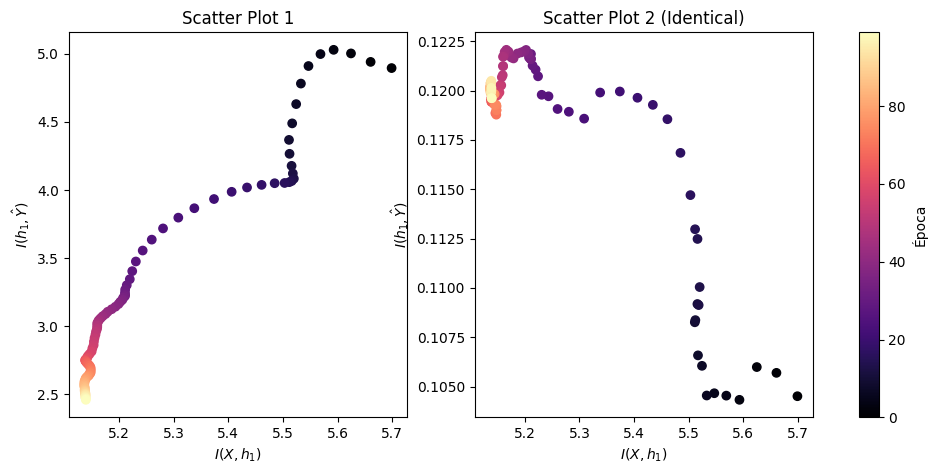

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

norm = Normalize(vmin=0, vmax=num_epochs - 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 

scatter1 = axs[0].scatter(mutual_info[0], mutual_info[4], c=np.arange(0, num_epochs), cmap='magma', norm=norm)
axs[0].set_xlabel('$I(X, h_1)$')
axs[0].set_ylabel('$I(h_1, \\hat Y)$')
axs[0].set_title('Scatter Plot 1') # Add a title for clarity

scatter2 = axs[1].scatter(mutual_info[0], mutual_info[10], c=np.arange(0, num_epochs), cmap='magma', norm=norm)
axs[1].set_xlabel('$I(X, h_1)$')
axs[1].set_ylabel('$I(h_1, \\hat Y)$')
axs[1].set_title('Scatter Plot 2 (Identical)') # Add a title for clarity

cbar = fig.colorbar(scatter1, ax=axs.ravel().tolist(), label='Época', orientation='vertical')
plt.tight_layout(rect=[1, 0.05, 0.95, 1]) # Adjust rect to leave space for colorbar on the right
plt.show()

In [ ]:
import numpy as np
mutual_info = []
for peso1 in np.linspace(0,10, 1000):
    y = torch.tanh(data*peso1)
    bins = torch.linspace(-1, 1, 30)
    indices = torch.bucketize(y, bins)
    mutual_info.append(ee.mi(data,indices))

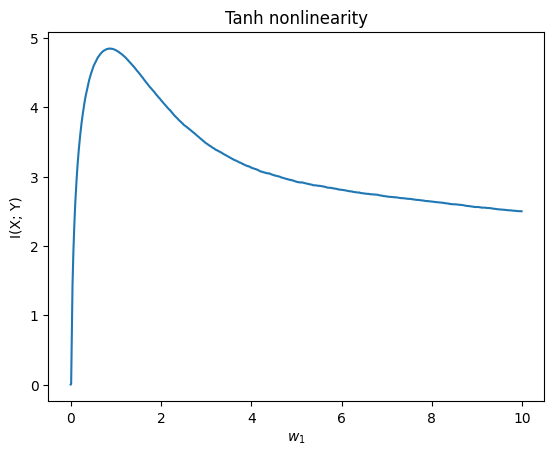

In [ ]:
plt.plot(np.arange(0,10, 1/100), mutual_info)
plt.title('Tanh nonlinearity')
plt.xlabel(r'$w_1$')
plt.ylabel('I(X; Y)')
plt.show()

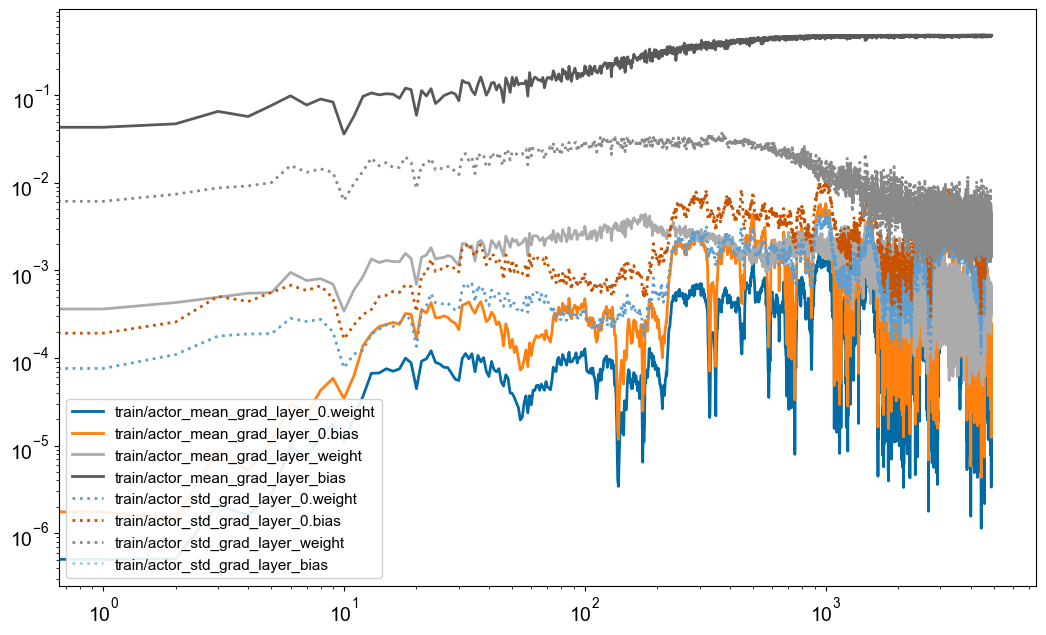

In [ ]:
# média e std - replicação Saxe
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('style.mplstyle')
df = pd.read_csv('teste/173/resultados.csv')
for column in df.filter(like = 'train/actor_mean').columns:
    plt.plot(df[column], label = column, linestyle = '-')
for column in df.filter(like = 'train/actor_std').columns:
    plt.plot(df[column], label = column, linestyle = 'dotted')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# Weights and Bias

In [28]:
import wandb
wandb.login()

True

In [29]:
from stable_baselines3.common.utils import explained_variance
from npeet import entropy_estimators as ee
from torch.nn import functional as F
from stable_baselines3 import PPO
from gymnasium import spaces
from typing import Optional
import pandas as pd
import numpy as np
import gymnasium
import itertools
import torch
import copy
import os
import wandb

from class_LQR_controller import Controller
from utils import tensor_to_numpy

class PPO_tunado(PPO):
        def __init__(self, policy: str, env: gymnasium.Env, tensorboard_log: str, hparams: dict):            
            super().__init__(policy, env, tensorboard_log= tensorboard_log, **hparams)
            # self.directory = os.path.join(directory, 'resultados.csv')
            self.calc_mutual_info = True
            self.reference_agent = None
            self.reference_control = None
            self.counter = 0
                        
        def train(self):
            """
            Update policy using the currently gathered rollout buffer.
            """
            # Switch to train mode (this affects batch norm / dropout)
            self.policy.set_training_mode(True)
            # Update optimizer learning rate
            self._update_learning_rate(self.policy.optimizer)
            # Compute current clip range
            clip_range = self.clip_range(self._current_progress_remaining)  # type: ignore[operator]
            # Optional: clip range for the value function
            if self.clip_range_vf is not None:
                clip_range_vf = self.clip_range_vf(self._current_progress_remaining)  # type: ignore[operator]

            entropy_losses = []
            pg_losses, value_losses = [], []
            clip_fractions = []

            continue_training = True
            
            # logging additions
            layer_size = len(self.policy_kwargs['net_arch'])
            measure_size = 2
            vec1 = [f'h_{i+1}' for i in range(layer_size)]
            vec1.insert(0, 'X') 
            vec2 = copy.copy(vec1)
            vec2.extend(['hat Y'])
            
            if self.reference_agent is not None:
                measure_size = measure_size + 2
                vec2.extend(['Y']) # type: ignore
            if self.reference_control is not None:
                measure_size = measure_size + 2
                vec2.extend(['Y_c']) # type: ignore
            
            mutual_info = {}
            ite = 0
            for i, j in enumerate(vec1):
                for k in vec2[i+1:]:
                    key = f"I({j},{k})"
                    mutual_info[key] = []  
                    ite += 1
            actor_net = list(itertools.chain(self.policy.mlp_extractor.policy_net.named_parameters(), self.policy.action_net.named_parameters()))
            critic_net = list(itertools.chain(self.policy.mlp_extractor.value_net.named_parameters(), self.policy.value_net.named_parameters()))
            
            # train for n_epochs epochs
            for epoch in range(self.n_epochs):
                metrics = {
                    'mutual_info': mutual_info,
                    'actor':{
                        'gradient': {key: [0] for key, _ in actor_net},
                        'weights': {key: [value.detach().clone().norm().cpu().numpy()] for key, value in actor_net},
                        'grad_mean': {key: [0] for key, _ in actor_net},
                        'grad_std': {key: [0] for key, _ in actor_net}
                    },
                    'critic':{
                        'gradient': {key: [0] for key, _ in critic_net},
                        'weights': {key: [value.detach().clone().norm().cpu().numpy()] for key, value in critic_net},
                        'grad_mean': {key: [0] for key, _ in critic_net},
                        'grad_std': {key: [0] for key, _ in critic_net}
                    }
                }

                tensor_policy_activations = {key: torch.tensor(0) for key in vec1}
                numpy_policy_activations = {}
                tensor_layers = {key: torch.tensor(0) for key in vec2}
                numpy_layers = {}
                approx_kl_divs = []
                # Do a complete pass on the rollout buffer
                for rollout_data in self.rollout_buffer.get(self.batch_size):
                    actions = rollout_data.actions
                    if isinstance(self.action_space, spaces.Discrete):
                        # Convert discrete action from float to long
                        actions = rollout_data.actions.long().flatten()

                    # Re-sample the noise matrix because the log_std has changed
                    if self.use_sde:
                        self.policy.reset_noise(self.batch_size)

                    values, log_prob, entropy = self.policy.evaluate_actions(rollout_data.observations, actions)
                    values = values.flatten()
                    # Normalize advantage
                    advantages = rollout_data.advantages
                    # Normalization does not make sense if mini batchsize == 1, see GH issue #325
                    if self.normalize_advantage and len(advantages) > 1:
                        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

                    # ratio between old and new policy, should be one at the first iteration
                    ratio = torch.exp(log_prob - rollout_data.old_log_prob)

                    # clipped surrogate loss
                    policy_loss_1 = advantages * ratio
                    policy_loss_2 = advantages * torch.clamp(ratio, 1 - clip_range, 1 + clip_range)
                    policy_loss = -torch.min(policy_loss_1, policy_loss_2).mean()

                    # Logging
                    pg_losses.append(policy_loss.item())
                    clip_fraction = torch.mean((torch.abs(ratio - 1) > clip_range).float()).item()
                    clip_fractions.append(clip_fraction)

                    if self.clip_range_vf is None:
                        # No clipping
                        values_pred = values
                    else:
                        # Clip the difference between old and new value
                        # NOTE: this depends on the reward scaling
                        
                        values_pred = rollout_data.old_values + torch.clamp(
                            values - rollout_data.old_values, -clip_range_vf, clip_range_vf #type: ignore
                        )
                    # Value loss using the TD(gae_lambda) target
                    value_loss = F.mse_loss(rollout_data.returns, values_pred)
                    value_losses.append(value_loss.item())

                    # Entropy loss favor exploration
                    if entropy is None:
                        # Approximate entropy when no analytical form
                        entropy_loss = -torch.mean(-log_prob)
                    else:
                        entropy_loss = -torch.mean(entropy)

                    entropy_losses.append(entropy_loss.item())

                    loss = policy_loss + self.ent_coef * entropy_loss + self.vf_coef * value_loss
                    # Calculate approximate form of reverse KL Divergence for early stopping
                    # see issue #417: https://github.com/DLR-RM/stable-baselines3/issues/417
                    # and discussion in PR #419: https://github.com/DLR-RM/stable-baselines3/pull/419
                    # and Schulman blog: http://joschu.net/blog/kl-approx.html
                    with torch.no_grad():
                        log_ratio = log_prob - rollout_data.old_log_prob
                        approx_kl_div = torch.mean((torch.exp(log_ratio) - 1) - log_ratio).cpu().numpy()
                        approx_kl_divs.append(approx_kl_div)

                    if self.target_kl is not None and approx_kl_div > 1.5 * self.target_kl:
                        continue_training = False
                        if self.verbose >= 1:
                            print(f"Early stopping at step {epoch} due to reaching max kl: {approx_kl_div:.2f}")
                        break

                    # Optimization step
                    self.policy.optimizer.zero_grad()
                    loss.backward()
                    # Clip grad norm
                    torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
                    self.policy.optimizer.step()

                    if self.calc_mutual_info:
                        with torch.no_grad():
                            entrada = self.policy.extract_features(rollout_data.observations)
                            assert (type(entrada) is torch.Tensor)
                            
                            ite = 1
                            tensor_policy_activations['X'] = entrada
                            x = entrada
                            for i, layer in enumerate(self.policy.mlp_extractor.policy_net):
                                x = layer(x)
                                if i % 2 == 1:  # A cada par de camadas (linear + ativação)
                                    tensor_policy_activations[vec1[ite]] = x
                                    ite = ite + 1

                            # todo: voltar pra adicionar isso aqui
                            # action_activations = [entrada]
                            # action_layers = [i for i in self.policy.mlp_extractor.value_net]
                            # for i in np.arange(0,len(action_layers),2):
                            #     action_activations.append(action_layers[i+1](action_layers[i](action_activations[int(i/2)])))
                            
                            for key in tensor_policy_activations.keys():
                                tensor_layers[key] = tensor_policy_activations[key]

                            # saídas para comparação
                            #saída da rede
                            tensor_layers['hat Y'] = self.policy.action_net(tensor_policy_activations[key])
                            #saída de controle
                            if self.reference_control is not None:
                                tensor_layers['Y_c'] = torch.tensor(self.reference_control.apply_state_controller(rollout_data.observations))
                            #saída do agente de referência
                            if self.reference_agent is not None:
                                tensor_layers['Y'] = self.reference_agent.predict(rollout_data.observations)[0] #type: ignore

                            for key in tensor_policy_activations.keys():
                                numpy_policy_activations[key] = tensor_to_numpy(tensor_policy_activations[key])
                            for key in tensor_layers.keys():
                                numpy_layers[key] = tensor_to_numpy(tensor_layers[key])
                            
                            
                            for key in metrics['mutual_info']:
                                key1, key2 = key.strip('I()').split(',')
                                metrics['mutual_info'][key].append(ee.mi(numpy_policy_activations[key1], numpy_layers[key2]))

                            # todo: verifica se alterar a ordem clone, grad e detach afeta o resulta de MI
                            for key, value in actor_net:
                                metrics['actor']['weights'][key].append(value.detach().clone().norm().cpu().numpy()) 
                                metrics['actor']['gradient'][key].append(value.grad.detach().clone().norm().cpu().numpy()) #type: ignore
                                metrics['actor']['grad_mean'][key].append(value.grad.detach().clone().mean().norm().cpu().numpy()) #type: ignore
                                if key != 'bias':
                                    metrics['actor']['grad_std'][key].append(value.grad.detach().clone().std().cpu().numpy()) #type: ignore
                            
                            for key, value in critic_net:
                                metrics['critic']['weights'][key].append(value.detach().clone().norm().cpu().numpy()) 
                                metrics['critic']['gradient'][key].append(value.grad.detach().clone().norm().cpu().numpy()) #type: ignore
                                metrics['critic']['grad_mean'][key].append(value.grad.detach().clone().mean().norm().cpu().numpy()) #type: ignore
                                if key != 'bias':
                                    metrics['critic']['grad_std'][key].append(value.grad.detach().clone().std().cpu().numpy()) #type: ignore
            with torch.no_grad():
                log_dict = {} # Dicionário para acumular todas as métricas
                log_dict['counter'] = self.counter
                # Métricas de mutual_info
                for key, values in metrics['mutual_info'].items():
                    log_dict[f"train/{key}"] = np.mean(values)

                # Métricas escalares principais
                log_dict["train/entropy_loss"] = np.mean(entropy_losses)
                log_dict["train/policy_gradient_loss"] = np.mean(pg_losses)
                log_dict["train/value_loss"] = np.mean(value_losses)
                log_dict["train/approx_kl"] = np.mean(approx_kl_divs)
                log_dict["train/clip_fraction"] = np.mean(clip_fractions)
                log_dict["train/loss"] = loss.item()

                # Métricas do ator
                for key in metrics['actor']['gradient'].keys():
                    log_dict[f"train/actor_weight_layer_{key}"] = np.mean(metrics['actor']['weights'][key])
                    log_dict[f"train/actor_grad_layer_{key}"] = np.mean(metrics['actor']['gradient'][key])
                    log_dict[f"train/actor_mean_grad_layer_{key}"] = np.mean(metrics['actor']['grad_mean'][key])
                    log_dict[f"train/actor_std_grad_layer_{key}"] = np.mean(metrics['actor']['grad_std'][key])
                
                # Métricas do crítico
                for key in metrics['critic']['gradient'].keys():
                    log_dict[f"train/critic_weight_layer_{key}"] = np.mean(metrics['critic']['weights'][key])
                    log_dict[f"train/critic_grad_layer_{key}"] = np.mean(metrics['critic']['gradient'][key])
                    log_dict[f"train/critic_mean_grad_layer_{key}"] = np.mean(metrics['critic']['grad_mean'][key])
                    log_dict[f"train/critic_std_grad_layer_{key}"] = np.mean(metrics['critic']['grad_std'][key])

                # Métricas condicionais
                if hasattr(self.policy, "log_std"):
                    log_dict["train/std"] = torch.exp(self.policy.log_std).mean().item()

                if self.clip_range_vf is not None:
                    log_dict["train/clip_range_vf"] = self.clip_range_vf # Se for um valor numérico

                wandb.log(log_dict) 
                self.counter = self.counter + 1

In [30]:
import gymnasium
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
import wandb
from wandb.integration.sb3 import WandbCallback


config = {
    "policy_type": "MlpPolicy",
    "total_timesteps": int(1e6),
    "env_name": "CartPole-v1",
}
run = wandb.init(
    project="gymansium_teste",
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)


def make_env():
    env = gymnasium.make(config["env_name"], render_mode = 'rgb_array')
    env = Monitor(env)  # record stats such as returns
    return env

env = make_env()
# env = VecVideoRecorder(env, f"videos/{run.id}", record_video_trigger=lambda x: x % 2000 == 0, video_length=200)
model = PPO_tunado(config["policy_type"], env, tensorboard_log=f"runs/{run.id}", hparams= dict(policy_kwargs = dict(net_arch=[32, 32])))
model.learn(
    total_timesteps=config["total_timesteps"],
    callback=WandbCallback(),
)
run.finish()


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
import gymnasium
import wandb
from wandb.integration.sb3 import WandbCallback

env = gymnasium.make('CartPole-v1', render_mode = 'human')
monitor_env = Monitor(env)
model = PPO('MlpPolicy', monitor_env)
seeds = [0]
# RecordVideo(train_env.get_attr('env')[0], video_folder= os.path.join(self.direc, 'videos'), episode_trigger= lambda x: x % self.recording_ep_freq == 0, disable_logger = True)

wandb.init(
    project= "gymansium_teste",    # Specify your project
    config={                         # Track hyperparameters and metadata
        "seeds": seeds
    },
    monitor_gym= True)

for seed in tqdm(seeds, desc="Training with different seeds"):
    model.set_random_seed(seed)
    model.learn(total_timesteps= int(1e3), progress_bar= True, callback=WandbCallback())

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Training with different seeds:   0%|          | 0/1 [00:00<?, ?it/s]

Output()

C:\Users\Arthur\AppData\Roaming\Python\Python310\site-packages\stable_baselines3\common\callbacks.py:718: TqdmExperimentalWarning: rich is experimental/alpha
  self.pbar = tqdm(total=self.locals["total_timesteps"] - self.model.num_timesteps)


Training with different seeds: 100%|██████████| 1/1 [00:45<00:00, 45.26s/it]


# Plots

In [ ]:
# Visualização
import gymnasium
import keyboard
import matplotlib.pyplot as plt
import numpy as np
from utils import fib

env = gymnasium.make('CartPole-v1')
modelo = teste.model

seeds = fib(2)
position = np.zeros((len(seeds), 500, 4))
modelo.set_random_seed(0)
for i, seed in enumerate(seeds):
    j = 0
    obs = env.reset(seed=seed)[0]
    done = False
    while not done:
        action, _ = modelo.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        position[i,j] = obs
        done = terminated or truncated
        j += 1
        if keyboard.is_pressed('esc'):
            break
    env.close()

C:\Users\Arthur\AppData\Local\Temp\ipykernel_34472\1873189405.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


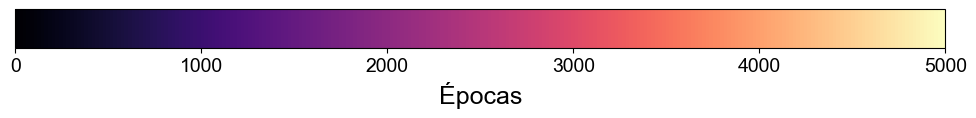

In [28]:
# Colorbar
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('style.mplstyle')

def create_shared_colorbar(vmin, vmax, cmap_name='viridis', filename='colorbar_unica.pdf'):
    """
    Gera uma barra de cores única e a salva como uma imagem.

    Args:
        vmin (float): Valor mínimo da escala de cor.
        vmax (float): Valor máximo da escala de cor.
        cmap_name (str): Nome do colormap a ser usado (e.g., 'viridis', 'plasma').
        filename (str): Nome do arquivo para salvar a barra de cores.
    """
    fig, ax = plt.subplots(figsize=(12, .5)) # Ajuste o tamanho para ser mais largo e fino
    
    # Cria um objeto ScalarMappable com a mesma escala e colormap das suas figuras
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(cmap_name)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) # Adiciona um array vazio para o ScalarMappable
    
    cbar = fig.colorbar(sm, cax=ax, orientation='horizontal')
    cbar.set_label('Épocas') # Ajuste a legenda conforme seus dados
    
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', dpi=300) # Salva com bordas ajustadas
    plt.show(fig)

# --- Exemplo de uso ---
# Substitua estes valores pelos valores reais da escala de suas 4 figuras
min_value = 0
max_value = 5000
colormap_used = 'magma' # Use o mesmo colormap que você usou nas 4 figuras

create_shared_colorbar(min_value, max_value, colormap_used, 'colorbar_unica.pdf')

In [ ]:
# conversor de plots para plot 2x2 de Informação mútua
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

plt.style.use('style.mplstyle')
vector = [169, 170, 171, 172, 174, 177, 180, 183, 186, 189, 190]
# vector = [186]
for indice in vector:
    directory = 'teste/' + str(indice)
    data = pd.read_csv(f'{directory}/resultados.csv')
    col_info = {col: [item.strip() for item in col.strip('train/I()').split(',')] for col in data.columns}
    combinacoes_sequenciais = []
    

    for col1, info1 in col_info.items():
        if len(info1) == 2:  # Certifica-se de que a coluna tem dois elementos (para ter um "segundo")
            segundo_elemento_col1 = info1[1]
            for col2, info2 in col_info.items():
                if col1 != col2 and len(info2) == 2:  # Evita comparar a mesma coluna e garante dois elementos
                    primeiro_elemento_col2 = info2[0]
                    if segundo_elemento_col1 == primeiro_elemento_col2:
                        combinacoes_sequenciais.append((col1, col2))
    size = len(data[combinacoes_sequenciais[0][0]])
    norm = Normalize(vmin=0, vmax= size)

    # Cria a figura com 4 subplots (2x2)
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.ravel()  # Transforma em array 1D para facilitar iteração
    subplot_labels = ['a)', 'b)', 'c)', 'd)']

    # Plota cada scatter com o mesmo colormap
    for i in range(4):
        col1 = combinacoes_sequenciais[i][0]
        col2 = combinacoes_sequenciais[i][1]
        scatter = axs[i].scatter(
            data[col1], 
            data[col2],
            c= np.arange(0, size),
            cmap= 'magma',
            norm=norm
        )
        col1 = col1.strip('train/')
        col2 = col2.strip('train/').replace('hat', '\\hat')

        title = f'Relação ${col1}-{col2}$'
        axs[i].set_title(title)
        axs[i].set_xlabel(f'${col1}$')
        axs[i].set_ylabel(f'${col2}$')
     
        axs[i].text(
        0.02, # Posição X (2% da largura do subplot a partir da esquerda)
        0.98, # Posição Y (98% da altura do subplot a partir de baixo)
        subplot_labels[i],
        transform=axs[i].transAxes, # MUITO IMPORTANTE: Usa as coordenadas relativas do Axes
        fontsize=16,           # Tamanho da fonte do rótulo
        fontweight='bold',     # Negrito
        va='top',              # Alinhamento vertical: topo do texto alinhado com 0.98
        ha='left'              # Alinhamento horizontal: esquerda do texto alinhada com 0.02
    )

    cbar_ax = fig.add_axes([1, 0.05, 0.025, 0.895])
    fig.colorbar(
        ScalarMappable(norm=norm, cmap='magma'),
        orientation='vertical',
        label='Épocas',
        cax=cbar_ax)

    plt.tight_layout()
    plt.savefig(f'{directory}-ip')
    plt.show()
    

In [ ]:
# histograma de evolução das observações
# dá pra analisar em como a entropia das distribuição diminui conforme o treinamento
# isso pode ser útil pra um método pra determinar o aprendizado do agente
import os
import pandas as pd
import matplotlib.pyplot as plt
for j, arquivo in enumerate(os.listdir('Coleta')):
   df = pd.read_csv(os.path.join('Coleta', arquivo))
   lista = ['Distribuição']
   for i in df.columns:
      if i in lista:
         plt.hist(df[i])
         plt.title(f'Histograma_{j}_{i}')
         plt.tight_layout()
         plt.show()
   else:
         continue

In [ ]:
# Evolução da entropia das variáveis do experimento
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import entropy
import numpy as np


scaler = MinMaxScaler()
base = pd.read_csv(f'Coleta/coleta_treino_000.csv')
lista = ['Iteração', 'Passo']

fig, axes = plt.subplots(3, 2, figsize=(15,9))
ite = 0
for i in base.columns:
    if i in lista:
        continue

    row = ite // 2  # Calculate row index based on column index
    col = ite % 2  # Calculate column index based on column index
    
    entropia = []
    for arquivo in os.listdir('Coleta'):
        df = pd.read_csv(os.path.join('Coleta', arquivo))
        df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
        counts, _ = np.histogram(df[i], bins=20, density=False)
        entropia.append(entropy(counts / df.shape[0]))

    axes[row, col].plot(entropia)
    axes[row, col].set_title(i)
    axes[row, col].set_xlabel('Iteration')
    axes[row, col].set_ylabel('Entropy')
    ite = ite + 1

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# teste para descobrir a probabilidade do modelo tomar uma certa ação

import numpy as np
value = np.zeros(1000)
dist = np.zeros((1000,2))
pos = np.linspace(-2.4, 2.4, 1000) #hã?
for i, j in enumerate(pos):
    tensor_obs = teste.model.policy.obs_to_tensor(np.array([j, 0, 0, 0]))[0]
    value[i] = teste.model.policy.predict_values(tensor_obs)[0,0].detach().numpy()
    dist[i] = teste.model.policy.get_distribution(tensor_obs).distribution.probs[0].clone().detach().cpu().numpy()

plt.plot(pos, dist)
plt.title('Ação')
plt.legend(['Esquerda', 'Direita'])
plt.show()

In [ ]:
# loss + recompensa
directory = 'teste/177'
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
loss_data = data.filter(like= 'loss')
loss_data.plot(title= 'Loss', ax=axs[0])  
axs[0].set_ylabel('Norma')
axs[0].set_xlabel('Época')
axs[0].legend()
axs[0].text(0.02,0.98,'a)', transform=axs[0].transAxes, va='top')

data_to_plot = pd.read_csv(f'{directory}/rewards.csv')
rewards = data_to_plot.T
means = rewards.apply(np.mean)
stds = rewards.apply(np.std)
axs[1].plot(means, label='Média', color='blue', marker='o')
axs[1].fill_between(
    range(len(means)),          # Eixo x (iterações)
    np.array(means) - np.array(stds),  # Limite inferior
    np.array(means) + np.array(stds),  # Limite superior
    alpha=0.2,                 # Transparência
    color='blue',
    label='±1 Desvio Padrão'
)
axs[1].set_xlabel('Iteração')
axs[1].set_ylabel('Recompensa')
axs[1].set_title('Distribuição das Recompensas por Iteração com Faixa de Desvio Padrão')
axs[1].legend()
axs[1].text(0.02,0.98,'b)', transform=axs[1].transAxes, va='top')
plt.tight_layout()
plt.savefig(f'{directory}/plots/loss+reward.pdf')
plt.close()

# Apresentação RL

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import DQN
import matplotlib.pyplot as plt
import gymnasium
import torch
import numpy
import time 

torch.manual_seed(1)
# numpy.random.seed(1)
while True:
    numpy.random.seed(int(time.time()))
    train_env = Monitor(gymnasium.make("CartPole-v1"))
    model = DQN("MlpPolicy", train_env, verbose=0)

    seeds = [1, 2, 3, 5, 8]
    for seed in seeds:
        model.set_random_seed(seed)
        model.learn(total_timesteps=int(2e5))

    eval_env = Monitor(gymnasium.make('CartPole-v1'))
    mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=int(1e3))

    train_rewards = numpy.array(train_env.get_episode_rewards())
    eval_rewards = numpy.array(eval_env.get_episode_rewards())

    figs, axs = plt.subplots(1,2, figsize=(12, 5))
    axs[0].plot(train_rewards)
    axs[0].set_ylim(0, 550)
    axs[0].set_xlabel('Episódios')
    axs[0].set_ylabel('Recompensa')
    axs[0].set_title('Treino')

    axs[1].plot(eval_rewards)
    axs[1].set_ylim(0, 550)
    axs[1].set_title('Validação')
    axs[1].set_xlabel('Episódios')
    axs[1].set_ylabel('Recompensa')
    plt.show()

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import DQN
import gymnasium
import numpy
import torch

# numpy.random.seed(1)
# torch.manual_seed(1)

train_env = Monitor(gymnasium.make('CartPole-v1'))
train_env.reset(seed=1)

model = DQN("MlpPolicy", train_env)

seeds = [1, 2, 3, 5, 8]
for seed in seeds:
    model.set_random_seed(seed)
    model.learn(total_timesteps=int(2e5))

eval_env = Monitor(gymnasium.make('CartPole-v1'))
eval_env.reset(seed=0)
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=int(1e3))

In [ ]:
import optuna
from typing import Union, Dict, Any

def sample_dqn_params(trial: Union[optuna.Trial, optuna.trial.FrozenTrial]) -> Dict[str, Any]:
    """
    Sampler for DQN hyperparams.

    :param trial:
    :return:
    """
    
    gamma = trial.suggest_categorical("gamma", [0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9999])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
    target_update_interval = trial.suggest_categorical("target_update_interval", np.arange(10,1001,10).tolist())
    train_freq = trial.suggest_categorical("train_freq", [1, 4, 8, 16, 32, 64])
    subsample_steps = trial.suggest_categorical("subsample_steps", [1, 2, 4, 8])
    gradient_steps = max(train_freq // subsample_steps, 1)

    hyperparams = {
        "gamma": gamma,
        "learning_rate": learning_rate,
        "train_freq": train_freq,
        "gradient_steps": gradient_steps,
        "target_update_interval": target_update_interval
    }

    return hyperparams

In [ ]:
from stable_baselines3.common.callbacks import EvalCallback
import gymnasium

class TrialEvalCallback(EvalCallback):
    """Callback used for evaluating and reporting a trial."""

    def __init__(
        self,
        eval_env: gymnasium.Env,
        trial: optuna.Trial,
        n_eval_episodes: int = 5,
        eval_freq: int = 1000,
        deterministic: bool = True,
        verbose: int = 0,
    ):
        super().__init__(
            eval_env=eval_env,
            n_eval_episodes=n_eval_episodes,
            eval_freq=eval_freq,
            deterministic=deterministic,
            verbose=verbose,
        )
        self.trial = trial
        self.eval_idx = 0
        self.is_pruned = False

    def _on_step(self) -> bool:
        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            super()._on_step()
            self.eval_idx += 1
            self.trial.report(self.last_mean_reward, self.eval_idx)
            # Prune trial if need.
            if self.trial.should_prune():
                self.is_pruned = True
                return False
        return True

In [ ]:
import torch
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

ENV_ID = "CartPole-v1"
DEFAULT_HYPERPARAMS = {
    "policy": "MlpPolicy",
    "env": ENV_ID,
}
N_EVAL_EPISODES = int(1e2)
EVAL_FREQ = int(1e3)
N_TIMESTEPS = int(2e4)

def objective(trial: optuna.Trial) -> float:
    # Sample hyperparameters.
    kwargs = sample_dqn_params(trial)
    # Create the RL model.
    np.random.seed(0)
    torch.manual_seed(0)
    model = DQN(policy='MlpPolicy', env=ENV_ID, **kwargs)
    # Create env used for evaluation.
    train_env = Monitor(gymnasium.make(ENV_ID))
    train_env.reset(seed=0)
    # Create the callback that will periodically evaluate and report the performance.
    eval_callback = TrialEvalCallback(
        train_env, trial, n_eval_episodes=N_EVAL_EPISODES, eval_freq=EVAL_FREQ, deterministic=True
    )

    nan_encountered = False
    try:
        model.set_random_seed(1)
        model.learn(N_TIMESTEPS, callback=eval_callback)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN.
        print(e)
        nan_encountered = True
    finally:
        # Free memory.
        model.env.close()
        train_env.close()

    # Tell the optimizer that the trial failed.
    if nan_encountered:
        return float("nan")

    if eval_callback.is_pruned:
        raise optuna.exceptions.TrialPruned()

    eval_env = Monitor(gymnasium.make(ENV_ID))
    mean, _ = evaluate_policy(model, eval_env, n_eval_episodes= int(1e2), return_episode_rewards= False)
    return mean 



In [43]:
import torch
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

N_STARTUP_TRIALS = int(1e1)
N_EVALUATIONS = int(3e1)
N_TRIALS = int(1e3)

#optuna.logging.set_verbosity(optuna.logging.ERROR)
torch.set_num_threads(1)

sampler = TPESampler(n_startup_trials=N_STARTUP_TRIALS, seed= 1)
# Do not prune before 1/3 of the max budget is used.
pruner = MedianPruner(n_startup_trials=N_STARTUP_TRIALS, n_warmup_steps=N_EVALUATIONS // 3)

study = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar= True)

[I 2025-06-22 22:22:10,500] A new study created in memory with name: no-name-ccf4a39b-0986-49e6-b391-2f5c0f1b4ebd


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-06-22 22:26:46,815] Trial 0 finished with value: 9.46 and parameters: {'gamma': 0.95, 'learning_rate': 0.0005343227125594117, 'batch_size': 256, 'buffer_size': 10000, 'exploration_final_eps': 0.039620297816975764, 'exploration_fraction': 0.40037228433776834, 'target_update_interval': 1, 'learning_starts': 5000, 'train_freq': 1, 'subsample_steps': 2}. Best is trial 0 with value: 9.46.
[I 2025-06-22 22:31:02,196] Trial 1 finished with value: 9.48 and parameters: {'gamma': 0.99, 'learning_rate': 1.2497835076619116e-05, 'batch_size': 16, 'buffer_size': 50000, 'exploration_final_eps': 0.13888003154554904, 'exploration_fraction': 0.20708963476345132, 'target_update_interval': 15000, 'learning_starts': 0, 'train_freq': 4, 'subsample_steps': 8}. Best is trial 1 with value: 9.48.
[I 2025-06-22 22:35:06,898] Trial 2 finished with value: 9.3 and parameters: {'gamma': 0.95, 'learning_rate': 0.0077973687275726105, 'batch_size': 64, 'buffer_size': 1000000, 'exploration_final_eps': 0.12467202

KeyboardInterrupt: 

In [44]:
study.best_trial
# [I 2025-06-22 15:04:04,770] Trial 16 finished with value: 500.0 and parameters: . Best is trial 16 with value: 500.0.


FrozenTrial(number=95, state=TrialState.COMPLETE, values=[287.97], datetime_start=datetime.datetime(2025, 6, 23, 9, 11, 48, 152632), datetime_complete=datetime.datetime(2025, 6, 23, 9, 20, 19, 669218), params={'gamma': 0.9999, 'learning_rate': 0.0037138435320511324, 'batch_size': 256, 'buffer_size': 10000, 'exploration_final_eps': 0.08305983003305907, 'exploration_fraction': 0.11071329647524848, 'target_update_interval': 5000, 'learning_starts': 1000, 'train_freq': 8, 'subsample_steps': 1}, user_attrs={}, system_attrs={}, intermediate_values={1: 9.386, 2: 9.346, 3: 9.354, 4: 9.332, 5: 9.349, 6: 9.381, 7: 9.39, 8: 9.352, 9: 9.36, 10: 9.374, 11: 11.014, 12: 10.756, 13: 10.716, 14: 10.2, 15: 9.55, 16: 9.368, 17: 9.323, 18: 9.386, 19: 9.388, 20: 9.331, 21: 9.823, 22: 9.345, 23: 9.35, 24: 9.778, 25: 9.332, 26: 9.979, 27: 9.406, 28: 9.561, 29: 9.794, 30: 9.408, 31: 9.414, 32: 10.409, 33: 9.348, 34: 9.846, 35: 9.371, 36: 9.351, 37: 11.832, 38: 9.349, 39: 10.051, 40: 9.476, 41: 9.762, 42: 9.33

In [1]:
# Treino do modelo com hiperparâmetros selecionados
from stable_baselines3.common.evaluation import evaluate_policy

np.random.seed(0)
torch.manual_seed(0)
# best_model_params = {
    # 'gamma': 0.99, 
    # 'learning_rate': 0.002, 
    # 'batch_size': 32, 
    # 'buffer_size': 50000, 
    # 'exploration_final_eps': 0.05, 
    # 'exploration_fraction': 0.2, 
    # 'target_update_interval': 1000, 
    # 'learning_starts': 0, 
    # 'train_freq': 32
    # }
best_model_params = sample_dqn_params(study.best_trial)

train_env = Monitor(gymnasium.make(ENV_ID))
best_model = DQN('MlpPolicy', train_env, **best_model_params)
train_env.reset(seed = 0)
seeds = [1, 2, 3, 5, 8]
for seed in seeds:
    best_model.set_random_seed(seed)
    best_model.learn(total_timesteps=int(2e5)*5)

eval_env = Monitor(gymnasium.make(ENV_ID))
eval_env.reset(seed = 0)
_, _ = evaluate_policy(best_model, eval_env, n_eval_episodes=int(1e3), return_episode_rewards = False)

NameError: name 'np' is not defined

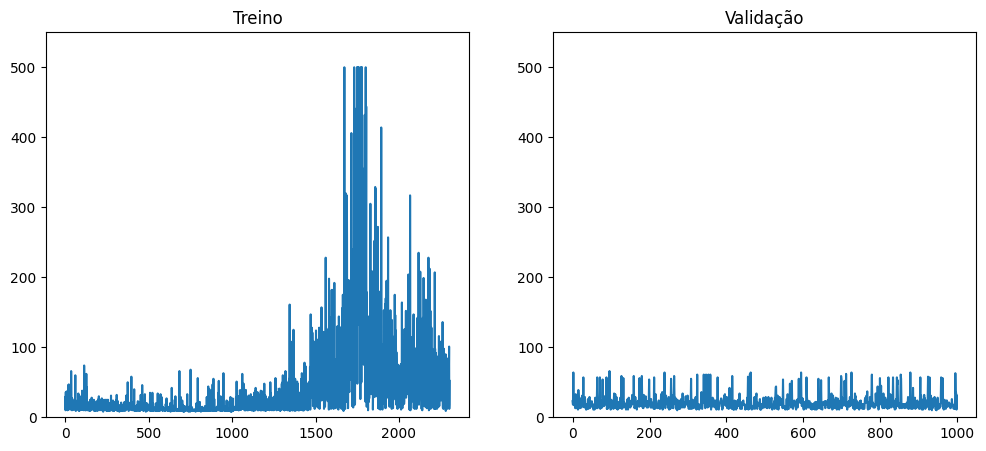

In [82]:
import matplotlib.pyplot as plt
import numpy as np

train_rewards = np.array(train_env.get_episode_rewards())
eval_rewards = np.array(eval_env.get_episode_rewards())

figs, axs = plt.subplots(1,2, figsize=(12, 5))
axs[0].plot(train_rewards)
axs[0].set_ylim(0, 550)
axs[0].set_title('Treino')

axs[1].plot(eval_rewards)
axs[1].set_ylim(0, 550)
axs[1].set_title('Validação')

plt.show()

In [ ]:
import gymnasium as gym
env = gym.make("LunarLander-v2")
observation, info = env.reset()

for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()
env.close()

In [ ]:
import gymnasium as gym
from stable_baselines3 import DQN

env = gym.make("LunarLander-v2")

model = DQN("MlpPolicy", env)
model.learn(total_timesteps = 1000)

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

plt.style.use('style.mplstyle')
directory = 'MountainCar-v0/000'


data = pd.read_csv(f'{directory}/resultados.csv')
col_info = {col: [item.strip() for item in col.strip('train/I()').split(',')] for col in data.columns}
combinacoes_sequenciais = []

# loss + recompensa
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
loss_data = data.filter(like= 'loss')
loss_data[2500:].plot(title= 'Loss', ax=axs[0])  
axs[0].set_ylabel('Norma')
axs[0].set_xlabel('Época')
axs[0].legend()
axs[0].text(0.02,0.98,'a)', transform=axs[0].transAxes, va='top')

data_to_plot = pd.read_csv(f'{directory}/rewards.csv')
rewards = data_to_plot[250:].T
means = rewards.apply(np.mean)
stds = rewards.apply(np.std)
axs[1].plot(means, label='Média', color='blue', marker='o')
axs[1].fill_between(
    np.arange(250,250 + len(means)),          # Eixo x (iterações)
    np.array(means) - np.array(stds),  # Limite inferior
    np.array(means) + np.array(stds),  # Limite superior
    alpha=0.2,                 # Transparência
    color='blue',
    label='±1 Desvio Padrão'
)
axs[1].set_xlabel('Iteração')
axs[1].set_ylabel('Recompensa')
axs[1].set_title('Distribuição das Recompensas por Iteração com Faixa de Desvio Padrão')
axs[1].legend()
axs[1].text(0.02,0.98,'b)', transform=axs[1].transAxes, va='top')
plt.tight_layout()
plt.savefig('loss+reward.pdf')
plt.close()

data = data[2500:]

# informação mútua
for col1, info1 in col_info.items():
    if len(info1) == 2:  # Certifica-se de que a coluna tem dois elementos (para ter um "segundo")
        segundo_elemento_col1 = info1[1]
        for col2, info2 in col_info.items():
            if col1 != col2 and len(info2) == 2:  # Evita comparar a mesma coluna e garante dois elementos
                primeiro_elemento_col2 = info2[0]
                if segundo_elemento_col1 == primeiro_elemento_col2:
                    combinacoes_sequenciais.append((col1, col2))
size = len(data[combinacoes_sequenciais[0][0]])
norm = Normalize(vmin=0, vmax= size)

if len(combinacoes_sequenciais) == 4:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.ravel()  # Transforma em array 1D para facilitar iteração
    subplot_labels = ['a)', 'b)', 'c)', 'd)']
    for i in range(4):
        col1 = combinacoes_sequenciais[i][0]
        col2 = combinacoes_sequenciais[i][1]
        axs[i].scatter(data[col1], data[col2],c= np.arange(0, size),cmap= 'magma',norm=norm)
        col1 = col1.strip('train/')
        col2 = col2.strip('train/').replace('hat', '\\hat')
        title = f'Relação ${col1}-{col2}$'
        axs[i].set_title(title)
        axs[i].set_xlabel(f'${col1}$')
        axs[i].set_ylabel(f'${col2}$')
        axs[i].text(0.02, 0.98, subplot_labels[i], transform=axs[i].transAxes, va='top')

    cbar_ax = fig.add_axes([1, 0.05, 0.025, 0.895]) #type: ignore
    fig.colorbar(
        ScalarMappable(norm=norm, cmap='magma'),
        orientation='vertical',
        label='Épocas',
        cax=cbar_ax)
    plt.tight_layout()
    plt.savefig(f'information_plots.pdf')
    plt.close()

C:\Users\Arthur\AppData\Local\Temp\ipykernel_32304\2961363658.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [87]:
import os
import pandas as pd
import glob
from tqdm import tqdm

directory = 'CartPole-v1' # Caminho para a pasta principal
csv_filename = 'resultados.csv' # Nome do arquivo CSV em cada subpasta

# Lista das colunas que você quer manter
columns_to_keep = [
    'train/I(X,h_1)',
    'train/I(X,h_2)',
    'train/I(X,hat Y)',
    'train/I(h_1,h_2)',
    'train/I(h_1,hat Y)',
    'train/I(h_2,hat Y)',
    'train/entropy_loss',
    'train/policy_gradient_loss',
    'train/value_loss',
    'train/loss'
]

all_results = [] # Lista para armazenar todos os DataFrames

# Encontrar todos os arquivos 'resultados.csv' em subdiretórios numerados
file_paths = glob.glob(os.path.join(directory, '[0-9]*', csv_filename))

if not file_paths:
    print(f"Nenhum arquivo '{csv_filename}' encontrado em subdiretórios de '{directory}'. Verifique o caminho.")

print("Carregando e combinando arquivos CSV (apenas as colunas especificadas)...")
for file_path in tqdm(file_paths, desc="Processando arquivos"):
    try:
        temp_df = pd.read_csv(file_path, usecols=columns_to_keep)
        temp_df['epoch_in_seed'] = temp_df.index # O índice é o passo/época
        seed_id = os.path.basename(os.path.dirname(file_path))
        temp_df['seed_id'] = seed_id

        all_results.append(temp_df)

    except FileNotFoundError:
        print(f"Erro: Arquivo não encontrado em {file_path}")
    except pd.errors.EmptyDataError:
        print(f"Aviso: Arquivo vazio em {file_path}. Ignorando.")
    except KeyError as e:
        print(f"Aviso: Uma ou mais colunas especificadas não foram encontradas em {file_path}: {e}. Ignorando.")
    except Exception as e:
        print(f"Erro inesperado ao ler {file_path}: {e}")

# Concatenar todos os DataFrames em um único DataFrame
if all_results:
    combined_df = pd.concat(all_results, ignore_index=True)
    print("\nDataFrame combinado com sucesso (apenas colunas selecionadas)!")
else:
    print("Nenhum arquivo CSV válido foi encontrado e combinado com as colunas especificadas.")

Carregando e combinando arquivos CSV (apenas as colunas especificadas)...


Processando arquivos: 100%|██████████| 146/146 [00:04<00:00, 32.25it/s]


DataFrame combinado com sucesso (apenas colunas selecionadas)!


In [118]:
columns_to_plot = [
    'train/I(X,h_1)',
    'train/I(X,h_2)',
    'train/I(X,hat Y)',
    'train/I(h_1,h_2)',
    'train/I(h_1,hat Y)',
    'train/I(h_2,hat Y)'
]

In [122]:
temp_df

,"train/I(X,h_1)","train/I(X,h_2)","train/I(X,hat Y)","train/I(h_1,h_2)","train/I(h_1,hat Y)","train/I(h_2,hat Y)",train/entropy_loss,train/policy_gradient_loss,train/value_loss,train/loss,epoch_in_seed,seed_id
1,2.965943,3.286698,0.289993,3.297641,0.542815,0.386604,-0.691234,-0.008787,94.222746,42.942810,1,000
4891,2.987855,3.300675,0.287420,3.331342,0.532650,0.367498,-0.691344,-0.006410,93.679026,54.038994,1,001
9781,3.043666,3.308915,0.288139,3.380733,0.546971,0.396912,-0.691395,-0.007388,89.995849,49.686092,1,002
14671,3.094000,3.346831,0.441341,3.390573,0.771388,0.573937,-0.690724,-0.009908,83.842861,39.031265,1,003
19561,3.025495,3.305056,0.262647,3.357602,0.506506,0.350702,-0.691712,-0.006663,88.191836,40.279263,1,004
...,...,...,...,...,...,...,...,...,...,...,...,...
689491,3.078328,3.357833,0.386350,3.412906,0.698362,0.504873,-0.691028,-0.009479,81.128993,40.013653,1,143
694381,3.056511,3.320547,0.315666,3.365797,0.604414,0.429917,-0.691280,-0.007141,78.631076,34.800407,1,144
699271,3.086720,3.330790,0.400040,3.394655,0.717814,0.536228,-0.690949,-0.008979,82.125928,49.742516,1,145
704161,2.981785,3.268907,0.228330,3.367188,0.451414,0.322936,-0.691602,-0.007531,90.891081,41.605286,1,146


In [136]:
for col1, info1 in col_info.items():
    if len(info1) == 2:  # Certifica-se de que a coluna tem dois elementos (para ter um "segundo")
        segundo_elemento_col1 = info1[1]
        for col2, info2 in col_info.items():
            if col1 != col2 and len(info2) == 2:  # Evita comparar a mesma coluna e garante dois elementos
                primeiro_elemento_col2 = info2[0]
                if segundo_elemento_col1 == primeiro_elemento_col2:
                    combinacoes_sequenciais.append((col1, col2))
size = len(temp_df[combinacoes_sequenciais[0][0]])
norm = Normalize(vmin=0, vmax= size)

In [ ]:
for col1, col2 in combinacoes_sequenciais:
    col1_name = col1.strip('train/')
    col2_name = col2.strip('train/').replace('hat', '\\hat')
    title = f'Relação ${col1_name}-{col2_name}$'
    for epoch in range(combined_df['epoch_in_seed'].max()):
        temp_df = combined_df[combined_df['epoch_in_seed']== epoch]
        
        plt.scatter(temp_df[col1], temp_df[col2], c= np.arange(0, size),cmap= 'magma',norm=norm)
        plt.title(title)
        plt.xlim(combined_df[col1].min(), combined_df[col1].max())
        plt.ylim(combined_df[col2].min(), combined_df[col2].max())
        plt.xlabel(f'${col1_name}$')
        plt.ylabel(f'${col2_name}$')
        plt.savefig(f'{title}/{str(epoch).zfill(4)}.jpg')
        plt.close()

Carregando arquivos para animação: 100%|██████████| 146/146 [00:03<00:00, 39.52it/s]



Dados combinados para animação. Total de linhas: 713940


C:\Users\Arthur\AppData\Local\Temp\ipykernel_22832\1796070765.py:94: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  scatters_per_subplot[i][seed] = axs[i].scatter([], [], s=10, cmap='magma', norm=norm_epoch)


Gerando vídeo da evolução dos planos de informação para todas as seeds (4890 frames)...


FileNotFoundError: [WinError 2] O sistema não pode encontrar o arquivo especificado

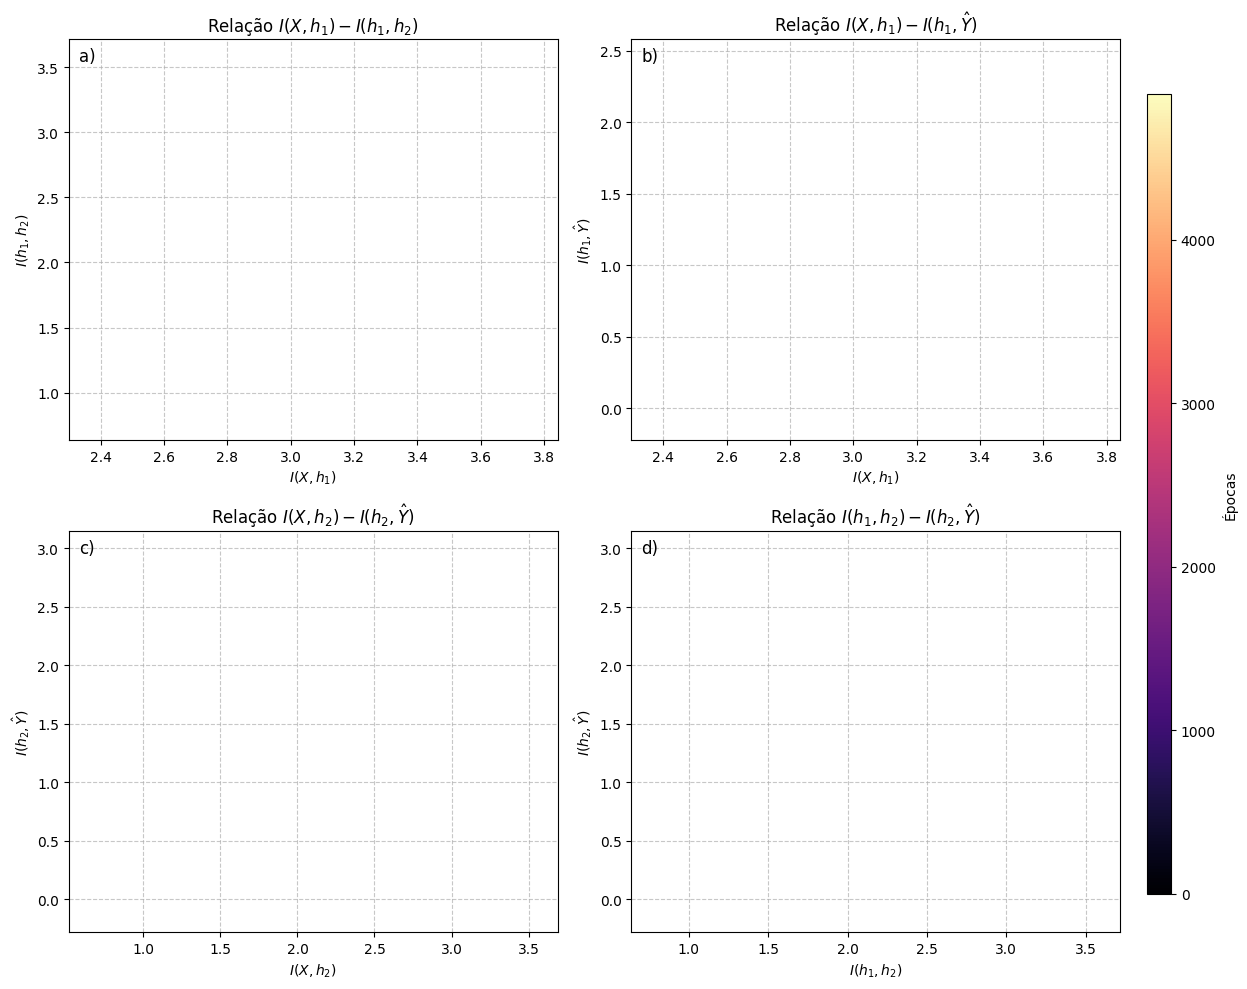

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
import glob
from tqdm import tqdm # Para barra de progresso
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


base_directory = 'CartPole-v1'
csv_filename = 'resultados.csv'


# Mapeamento das colunas para suas variáveis componentes
# Isso permite que o script encontre combinações com variáveis comuns
col_info = {
    'train/I(X,h_1)': ('X', 'h_1'),
    'train/I(X,h_2)': ('X', 'h_2'),
    'train/I(X,hat Y)': ('X', 'hat Y'),
    'train/I(h_1,h_2)': ('h_1', 'h_2'),
    'train/I(h_1,hat Y)': ('h_1', 'hat Y'),
    'train/I(h_2,hat Y)': ('h_2', 'hat Y')
}


def create_information_plane_animation(df, col_info, output_folder, fps = 30, dpi = 150, figsize = (12,10)):
    """
    Cria uma animação de vídeo para os planos de informação, mostrando a evolução
    de todas as seeds simultaneamente, frame a frame (por instante/época).
    """
    # 1. Encontrar as combinações sequenciais com uma variável em comum
    combinacoes_sequenciais = []
    for col1, info1 in col_info.items():
        if len(info1) == 2:
            segundo_elemento_col1 = info1[1]
            for col2, info2 in col_info.items():
                if col1 != col2 and len(info2) == 2:
                    primeiro_elemento_col2 = info2[0]
                    if segundo_elemento_col1 == primeiro_elemento_col2:
                        if col1 in df.columns and col2 in df.columns:
                            combinacoes_sequenciais.append((col1, col2))
                        else:
                            print(f"Aviso: Colunas '{col1}' ou '{col2}' não encontradas no DataFrame. Ignorando esta combinação.")

    if not combinacoes_sequenciais:
        print("Nenhuma combinação de colunas válidas encontrada para os planos de informação.")
        return

    # Garante que temos exatamente 4 combinações para o layout 2x2, ou ajusta o aviso
    if len(combinacoes_sequenciais) < 4:
        print(f"Aviso: Apenas {len(combinacoes_sequenciais)} combinações sequenciais foram encontradas. Esperado 4 para o layout 2x2. Ajuste o layout de subplots se necessário.")
        # Se você quiser que o script continue mesmo com menos de 4, pode ajustar o layout do subplot aqui.
        # Por exemplo: `rows = (len(combinacoes_sequenciais) + 1) // 2`, `cols = 2`
        # Para este exemplo, manteremos a suposição de 4 para o layout fixo.
        return
    elif len(combinacoes_sequenciais) > 4:
        print(f"Aviso: Mais de 4 combinações sequenciais foram encontradas ({len(combinacoes_sequenciais)}). Apenas as 4 primeiras serão plotadas.")
        combinacoes_sequenciais = combinacoes_sequenciais[:4]


    fig, axs = plt.subplots(2, 2, figsize=figsize)
    axs = axs.ravel() # Transforma em array 1D para facilitar iteração
    subplot_labels = ['a)', 'b)', 'c)', 'd)']
    
    # Prepara os scatter plots para cada subplot
    # Cada semente terá seu próprio conjunto de pontos dentro de cada subplot
    scatters_per_subplot = [{} for _ in range(len(combinacoes_sequenciais))]
    seeds = df['seed_id'].unique() # Usar 'seed_id' conforme o código de carregamento
    
    # Para a colorbar de épocas (normalização global para todas as épocas)
    max_epoch_overall = df['epoch_in_seed'].max() + 1
    norm_epoch = Normalize(vmin=0, vmax=max_epoch_overall)
    
    # Configuração inicial dos subplots (limites fixos para a animação)
    for i in range(len(combinacoes_sequenciais)):
        col1_name, col2_name = combinacoes_sequenciais[i]
        
        # Define os limites dos eixos com base em TODOS os dados (min/max global)
        min_x_i, max_x_i = df[col1_name].min(), df[col1_name].max()
        min_y_i, max_y_i = df[col2_name].min(), df[col2_name].max()
        
        # Expansão para garantir que os pontos não fiquem na borda
        range_x_i = max_x_i - min_x_i
        range_y_i = max_y_i - min_y_i
        
        axs[i].set_xlim(min_x_i - range_x_i * 0.1, max_x_i + range_x_i * 0.1)
        axs[i].set_ylim(min_y_i - range_y_i * 0.1, max_y_i + range_y_i * 0.1)
        
        # Cria um scatter plot vazio para cada semente dentro de cada subplot
        # O 'cmap' e 'norm' são definidos aqui para que a coloração por época funcione.
        for seed in seeds:
            scatters_per_subplot[i][seed] = axs[i].scatter([], [], s=10, cmap='magma', norm=norm_epoch)

        # Rótulos e Títulos (limpeza dos nomes para os rótulos LaTeX)
        clean_col1 = col1_name.strip('train/').replace('hat', '\\hat')
        clean_col2 = col2_name.strip('train/').replace('hat', '\\hat')
        
        title = f'Relação ${clean_col1}-{clean_col2}$'
        axs[i].set_title(title)
        axs[i].set_xlabel(f'${clean_col1}$')
        axs[i].set_ylabel(f'${clean_col2}$')
        axs[i].text(0.02, 0.98, subplot_labels[i], transform=axs[i].transAxes, va='top', fontsize=12)
        axs[i].grid(True, linestyle='--', alpha=0.7)
        
    plt.tight_layout(rect=[0, 0, 0.95, 1]) # Ajusta para dar espaço para a colorbar

    # Adicionar a colorbar global para as épocas
    cbar_ax = fig.add_axes([0.96, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(
        ScalarMappable(norm=norm_epoch, cmap='magma'),
        orientation='vertical',
        label='Épocas',
        cax=cbar_ax
    )

    def init():
        """Inicializa os plots no início da animação (vazios)."""
        all_artists = []
        for i in range(len(combinacoes_sequenciais)):
            for seed in seeds:
                scatters_per_subplot[i][seed].set_offsets(np.empty((0, 2))) # Limpa os pontos
            all_artists.extend(list(scatters_per_subplot[i].values()))
        return all_artists

    def update(frame_idx):
        """
        Atualiza os plots para o frame_idx (época) atual,
        adicionando pontos até essa época para todas as seeds.
        """
        current_artists = []
        
        # Itera sobre cada semente
        for seed_idx, seed in enumerate(seeds):
            # Filtra os dados para a semente atual, incluindo todas as épocas até o frame_idx
            # Isso faz com que os pontos se acumulem ao longo da animação
            subset_seed = df[(df['seed_id'] == seed) & (df['epoch_in_seed'] <= frame_idx)]

            if not subset_seed.empty:
                # Para cada subplot
                for plot_idx in range(len(combinacoes_sequenciais)):
                    col1_name, col2_name = combinacoes_sequenciais[plot_idx]
                    
                    # Obtém os pontos (coordenadas x, y) para o scatter plot
                    points = np.c_[subset_seed[col1_name], subset_seed[col2_name]]
                    # Obtém os valores de época para colorir os pontos
                    colors_data = subset_seed['epoch_in_seed'].values
                    
                    # Atualiza os offsets (posições dos pontos) e as cores do scatter plot
                    scatters_per_subplot[plot_idx][seed].set_offsets(points)
                    scatters_per_subplot[plot_idx][seed].set_array(colors_data)
                    
                    current_artists.append(scatters_per_subplot[plot_idx][seed])
        
        # Atualiza o título principal da figura com a época atual
        if not df.empty:
            current_epoch_val = frame_idx
            fig.suptitle(f'Evolução dos Planos de Informação (Época: {current_epoch_val:.0f})', fontsize=16, y=0.98)

        return current_artists

    # O número total de frames é o máximo de 'epoch_in_seed' + 1 (para incluir a época 0)
    num_frames = df['epoch_in_seed'].max() + 1
    
    # Cria o diretório de saída se não existir
    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, f'evolucao_planos_informacao_todos_seeds.mp4')

    print(f"Gerando vídeo da evolução dos planos de informação para todas as seeds ({num_frames} frames)...")
    ani = animation.FuncAnimation(fig, update, frames=num_frames,
                                  init_func=init, blit=True, interval=(1000/fps), repeat=False)

    writer = animation.FFMpegWriter(fps=fps, metadata=dict(artist='Arthur Fernandes'))
    ani.save(output_path, writer=writer, dpi=dpi)
    plt.close(fig) # Fecha a figura para não sobrecarregar a memória
    print(f"Vídeo salvo em: {output_path}")

# (Mantenha o bloco if __name__ == "__main__": do script anterior para execução)
if __name__ == "__main__":
    # Certifique-se de que 'load_and_combine_data' e as variáveis de configuração estão definidas
    # antes de executar este bloco.
    
    # Exemplo de uso (você precisará ter as outras partes do código no mesmo arquivo ou importá-las):
    # directory = 'CartPole-v1' # Seu diretório base
    # csv_filename = 'resultados.csv'
    # columns_to_keep = ['train/I(X,h_1)', 'train/I(X,h_2)', 'train/I(X,hat Y)',
    #                    'train/I(h_1,h_2)', 'train/I(h_1,hat Y)', 'train/I(h_2,hat Y)',
    #                    'train/entropy_loss', 'train/policy_gradient_loss', 'train/value_loss', 'train/loss']
    
    # combined_data = load_and_combine_data_filtered(directory, csv_filename, columns_to_keep) # Use a função filtrada
    
    # Substitua as linhas acima pela sua forma de carregar os dados
    # Para demonstração, vou chamar a função de carregamento completa:
    # IMPORTANTE: A função load_and_combine_data_filtered não foi definida aqui,
    # use a versão mais recente que filtra as colunas.
    
    # Exemplo para garantir que combined_data esteja pronto:
    directory = 'CartPole-v1' # Caminho para a pasta principal (ajuste se necessário)
    csv_filename = 'resultados.csv'
    columns_to_keep = [
        'train/I(X,h_1)', 'train/I(X,h_2)', 'train/I(X,hat Y)',
        'train/I(h_1,h_2)', 'train/I(h_1,hat Y)', 'train/I(h_2,hat Y)',
        'train/entropy_loss', 'train/policy_gradient_loss', 'train/value_loss', 'train/loss'
    ]

    all_results_dfs = []
    file_paths = glob.glob(os.path.join(directory, '[0-9]*', csv_filename))
    for file_path in tqdm(file_paths, desc="Carregando arquivos para animação"):
        try:
            temp_df = pd.read_csv(file_path, usecols=columns_to_keep)
            temp_df['epoch_in_seed'] = temp_df.index
            temp_df['seed_id'] = os.path.basename(os.path.dirname(file_path))
            all_results_dfs.append(temp_df)
        except Exception as e:
            # print(f"Erro ao carregar {file_path}: {e}") # Descomente para ver erros durante o carregamento
            pass # Ignora erros para prosseguir com o que foi carregado

    if all_results_dfs:
        combined_data = pd.concat(all_results_dfs, ignore_index=False)
        combined_data = combined_data.sort_values(by=['seed_id', 'epoch_in_seed']).reset_index(drop=True)
        print(f"\nDados combinados para animação. Total de linhas: {len(combined_data)}")
        
        output_video_dir = os.path.join(directory, 'animated_information_plots')
        create_information_plane_animation(combined_data, col_info, output_video_dir)
    else:
        print("Nenhum dado válido para criar a animação.")

In [20]:
loss_data.max()

train/entropy_loss             -0.162086
train/policy_gradient_loss      0.002602
train/value_loss              152.972699
train/loss                    134.694260
dtype: float64

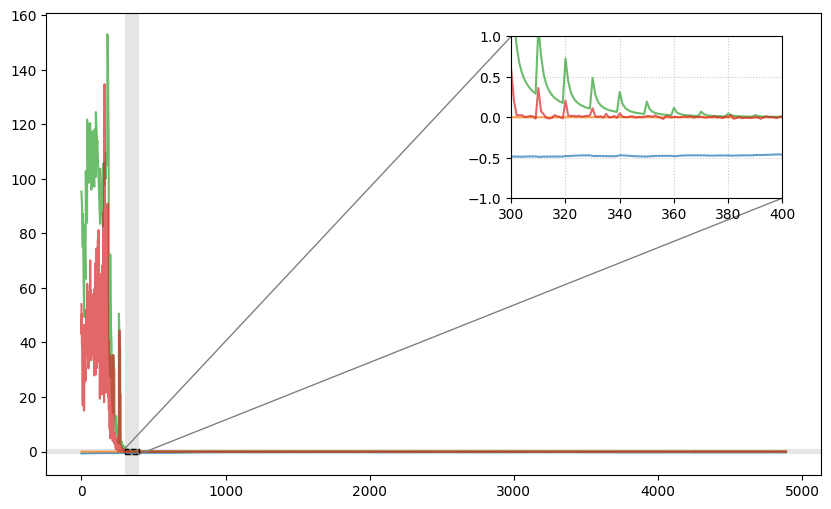

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
path = r'C:\Users\Arthur\Documents\GitHub\Dissertacao\CartPole-v1\000\resultados.csv'

data = pd.read_csv(path)
loss_data = data.filter(like= 'loss')
fig, ax = plt.subplots(figsize=(10, 6))

# Plot principal
ax.plot(loss_data, label='Sinal', alpha=0.7)

x_zoom_start, x_zoom_end = 300, 400
y_zoom_start, y_zoom_end = -1, 1

ax.axvspan(x_zoom_start, x_zoom_end, color='gray', alpha=0.2, lw=0)
ax.axhspan(y_zoom_start, y_zoom_end, color='gray', alpha=0.2, lw=0)
ax.plot([x_zoom_start, x_zoom_end, x_zoom_end, x_zoom_start, x_zoom_start],
        [y_zoom_start, y_zoom_start, y_zoom_end, y_zoom_end, y_zoom_start],
        color='black', linestyle='--', linewidth=1)
ax_zoom = ax.inset_axes([0.6, 0.6, 0.35, 0.35]) # Posiciona no canto superior direito do plot
ax_zoom.plot(loss_data, label='Sinal Ruidoso', alpha=0.7)
ax_zoom.set_xlim(x_zoom_start, x_zoom_end)
ax_zoom.set_ylim(y_zoom_start, y_zoom_end)
ax_zoom.grid(True, linestyle=':', alpha=0.7)
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, ax_zoom, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

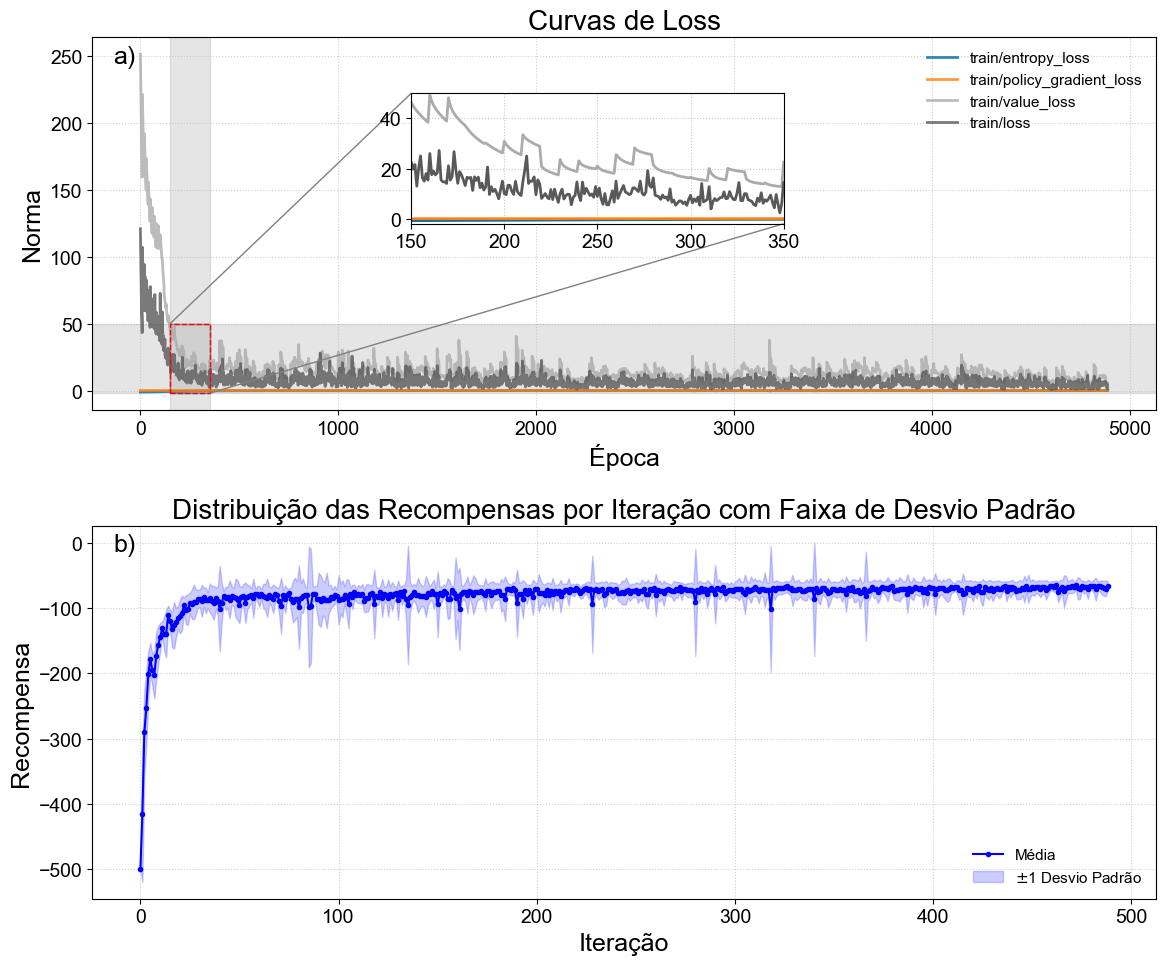

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
plt.style.use('style.mplstyle')

directory = r'C:\Users\Arthur\Documents\GitHub\Dissertacao\realoficial\002'
path_rewards = f'{directory}/rewards.csv' # Se estiver em um método de classe
data_loss = pd.read_csv(f'{directory}/resultados.csv')
data_rewards = pd.read_csv(path_rewards)

loss_data_filtered = data_loss.filter(like='loss')
fig, axs = plt.subplots(2, 1, figsize=(12, 10)) # Cria 2 subplots em uma coluna

x_zoom_start, x_zoom_end = 150, 350
y_zoom_start, y_zoom_end = -2,50

# Plot principal da Loss em axs[0]
loss_data_filtered.plot(ax=axs[0], alpha=0.8)
axs[0].set_title('Curvas de Loss', loc='center') # Título centralizado
axs[0].set_ylabel('Norma')
axs[0].set_xlabel('Época')
axs[0].legend(loc='upper right', frameon=False) # Legenda sem moldura
axs[0].text(0.02, 0.98, 'a)', transform=axs[0].transAxes, va='top')
axs[0].grid(True, linestyle=':', alpha=0.6)

# Desenhar o retângulo e as linhas de conexão no plot de Loss
axs[0].axvspan(x_zoom_start, x_zoom_end, color='gray', alpha=0.2)
axs[0].axhspan(y_zoom_start, y_zoom_end, color='gray', alpha=0.2)
axs[0].plot([x_zoom_start, x_zoom_end, x_zoom_end, x_zoom_start, x_zoom_start],
             [y_zoom_start, y_zoom_start, y_zoom_end, y_zoom_end, y_zoom_start],
             color='red', linestyle='--', linewidth=1, label='Área de Zoom')

# Criar o inset axes no plot de Loss
ax_zoom = axs[0].inset_axes([0.3, 0.5, 0.35, 0.35]) # [left, bottom, width, height]
ax_zoom.plot(loss_data_filtered)
ax_zoom.set_xlim(x_zoom_start, x_zoom_end)
ax_zoom.set_ylim(y_zoom_start, y_zoom_end)
ax_zoom.grid(True, linestyle=':', alpha=0.7)
mark_inset(axs[0], ax_zoom, loc1=2, loc2=4, fc="none", ec="0.5") # loc1 e loc2 definem os cantos de conexão

# segundo zoom
# x_zoom_start, x_zoom_end = 3000, 3200
# y_zoom_start, y_zoom_end = -5, 10

# axs[0].axvspan(x_zoom_start, x_zoom_end, color='gray', alpha=0.2)
# axs[0].axhspan(y_zoom_start, y_zoom_end, color='gray', alpha=0.2)
# axs[0].plot([x_zoom_start, x_zoom_end, x_zoom_end, x_zoom_start, x_zoom_start],
#              [y_zoom_start, y_zoom_start, y_zoom_end, y_zoom_end, y_zoom_start],
#              color='red', linestyle='--', linewidth=1, label='Área de Zoom')
# ax_zoom = axs[0].inset_axes([0.625, 0.35, 0.35, 0.35]) # [left, bottom, width, height]
# ax_zoom.plot(loss_data_filtered)
# ax_zoom.set_xlim(x_zoom_start, x_zoom_end)
# ax_zoom.set_ylim(y_zoom_start, y_zoom_end)
# ax_zoom.grid(True, linestyle=':', alpha=0.7)
# mark_inset(axs[0], ax_zoom, loc1=2, loc2=4, fc="none", ec="0.5") # loc1 e loc2 definem os cantos de conexão


# --- Configuração do Plot de Recompensa (axs[1]) ---
data_rewards = data_rewards.T
rewards_means = data_rewards.apply(np.mean)
rewards_stds = data_rewards.apply(np.std)

axs[1].plot(rewards_means, label='Média', color='blue', marker='o', markersize=3, linewidth=1.5)
axs[1].fill_between(
    range(len(rewards_means)),
    np.array(rewards_means) - np.array(rewards_stds),
    np.array(rewards_means) + np.array(rewards_stds),
    alpha=0.2,
    color='blue',
    label='$\\pm$1 Desvio Padrão'
)
axs[1].set_xlabel('Iteração')
axs[1].set_ylabel('Recompensa')
axs[1].set_title('Distribuição das Recompensas por Iteração com Faixa de Desvio Padrão', loc='center')
axs[1].legend(loc='lower right', frameon=False) # Legenda sem moldura
axs[1].text(0.02, 0.98, 'b)', transform=axs[1].transAxes, va='top')
axs[1].grid(True, linestyle=':', alpha=0.6)

nn.Tanh
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.savefig('loss+reward.pdf')
plt.show()

C:\Users\Arthur\AppData\Local\Temp\ipykernel_34472\421325914.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


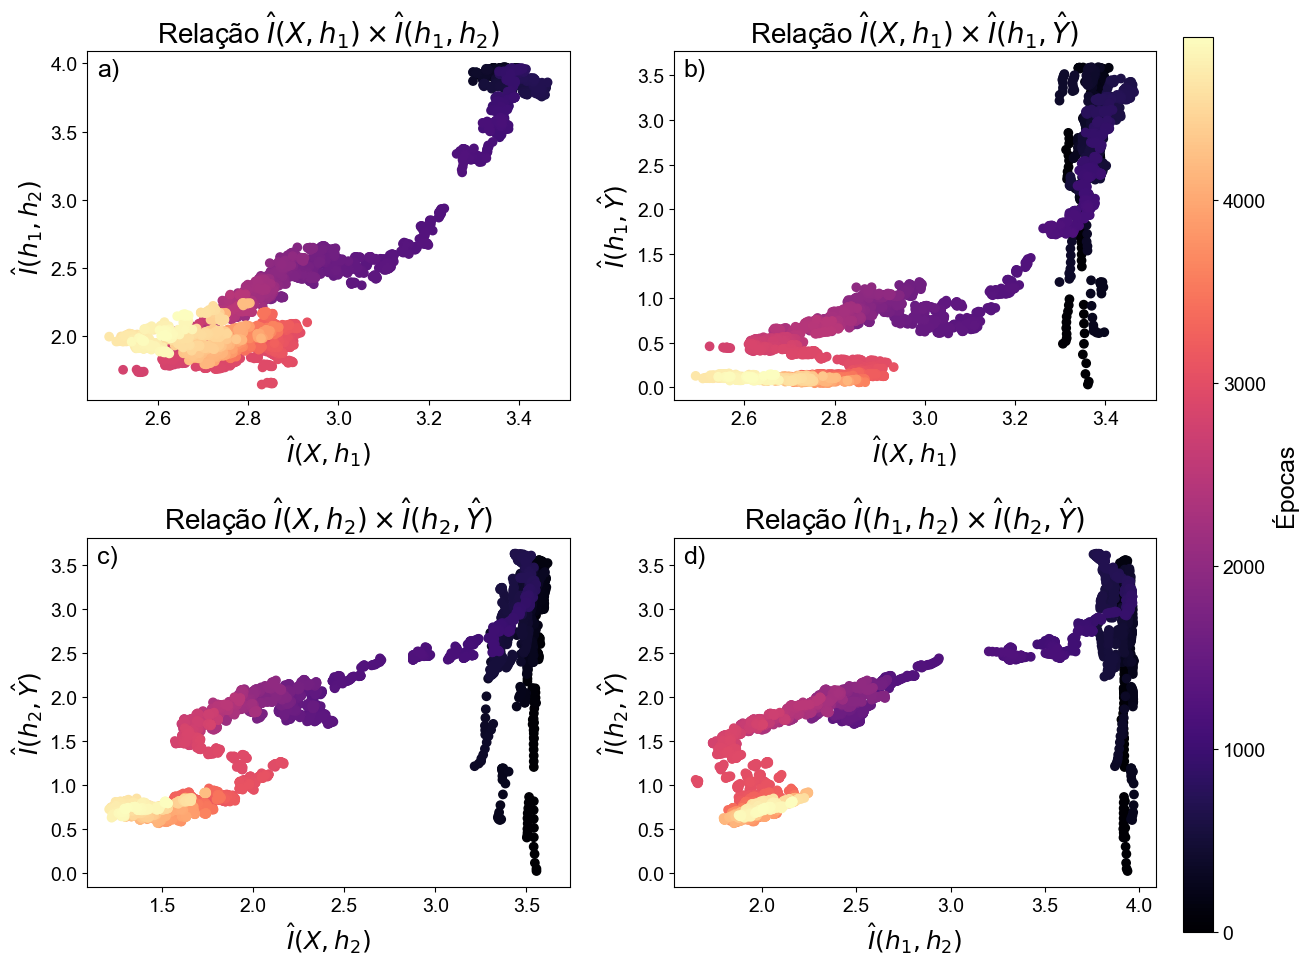

In [7]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use('style.mplstyle')

directory = r'C:\Users\Arthur\Documents\GitHub\Dissertacao\MountainCar-v0\000'
data = pd.read_csv(f'{directory}/resultados.csv')
col_info = {col: [item.strip() for item in col.strip('train/I()').split(',')] for col in data.columns}
combinacoes_sequenciais = []
# informação mútua
for col1, info1 in col_info.items():
    if len(info1) == 2:  # Certifica-se de que a coluna tem dois elementos (para ter um "segundo")
        segundo_elemento_col1 = info1[1]
        for col2, info2 in col_info.items():
            if col1 != col2 and len(info2) == 2:  # Evita comparar a mesma coluna e garante dois elementos
                primeiro_elemento_col2 = info2[0]
                if segundo_elemento_col1 == primeiro_elemento_col2:
                    combinacoes_sequenciais.append((col1, col2))
size = len(data[combinacoes_sequenciais[0][0]])
norm = Normalize(vmin=0, vmax= size)

if len(combinacoes_sequenciais) == 4:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.ravel()  # Transforma em array 1D para facilitar iteração
    subplot_labels = ['a)', 'b)', 'c)', 'd)']
    for i in range(4):
        col1 = combinacoes_sequenciais[i][0]
        col2 = combinacoes_sequenciais[i][1]
        axs[i].scatter(data[col1], data[col2],c= np.arange(0, size),cmap= 'magma',norm=norm)
        col1 = col1.strip('train/').replace('I', '\\hat I')
        col2 = col2.strip('train/').replace('hat', '\\hat').replace('I', '\\hat I')
        title = f'Relação ${col1}\\times {col2}$'
        axs[i].set_title(title)
        axs[i].set_xlabel(f'${col1}$')
        axs[i].set_ylabel(f'${col2}$')
        axs[i].text(0.02, 0.98, subplot_labels[i], transform=axs[i].transAxes, va='top')

    cbar_ax = fig.add_axes([1, 0.05, 0.025, 0.895]) #type: ignore
    fig.colorbar(
        ScalarMappable(norm=norm, cmap='magma'),
        orientation='vertical',
        label='Épocas',
        cax=cbar_ax)
    plt.tight_layout()
    # plt.savefig(f'{directory}/plots/information_plots.pdf')
    plt.show()

In [36]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
plt.style.use('style.mplstyle')

directory = r'C:\Users\Arthur\Documents\GitHub\Dissertacao\realoficial/003'
data = pd.read_csv(f'{directory}/resultados.csv')
col_info = {col: [item.strip() for item in col.strip('train/I()').split(',')] for col in data.columns}
combinacoes_sequenciais = []
# informação mútua
for col1, info1 in col_info.items():
    if len(info1) == 2:  # Certifica-se de que a coluna tem dois elementos (para ter um "segundo")
        segundo_elemento_col1 = info1[1]
        for col2, info2 in col_info.items():
            if col1 != col2 and len(info2) == 2:  # Evita comparar a mesma coluna e garante dois elementos
                primeiro_elemento_col2 = info2[0]
                if segundo_elemento_col1 == primeiro_elemento_col2:
                    combinacoes_sequenciais.append((col1, col2))
size = len(data[combinacoes_sequenciais[0][0]])
norm = Normalize(vmin=0, vmax= size)

for col1, col2 in combinacoes_sequenciais:
    val1 = data[col1]
    val2 = data[col2]
    plt.scatter(val1, val2, c= np.arange(0, len(data[col1])), cmap= 'magma')
    col1 = col1.strip('train/')
    col2 = col2.strip('train/').replace('hat', '\\hat')
    title = f'Relação ${col1} \\times {col2}$'
    plt.xlabel(f'${col1}$')
    plt.ylabel(f'${col2}$')
    plt.title(title)
    title = title.replace('\\', '')
    # plt.colorbar(label='Épocas')
    plt.tight_layout()
    plt.savefig(f'{directory}/plots/{title}.pdf')
    plt.close()


In [11]:
from pynput import keyboard
from pynput.keyboard import Key, KeyCode

def on_press(key: Key | KeyCode | None) -> bool:
    try:
        if key == Key.esc:
            print('Tecla Esc pressionada! Encerrando...')
            # Retorna False para parar o Listener. O Pylance pode ainda reclamar,
            # mas é a forma oficial da biblioteca.
            return False
    except AttributeError:
        pass
    # Se a tecla não for 'esc', continua escutando (retorna True)
    return True

# Cria o listener e o inicia
with keyboard.Listener(on_press=on_press) as listener: #type: ignore
    for i in range(10):
        print(i)
        listener.join()


0
Tecla Esc pressionada! Encerrando...
1
2
3


KeyboardInterrupt: 